# Affichage des lignes d'un volume à partir de la base HORAE

# Environnement

## Librairies

In [1]:
!conda info


     active environment : base
    active env location : /home/stutzmann/anaconda3
            shell level : 1
       user config file : /home/stutzmann/.condarc
 populated config files : /home/stutzmann/.condarc
          conda version : 4.12.0
    conda-build version : 3.21.8
         python version : 3.9.12.final.0
       virtual packages : __linux=5.19.0=0
                          __glibc=2.35=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/stutzmann/anaconda3  (writable)
      conda av data dir : /home/stutzmann/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/stutzmann/anaconda3/pkgs
                        

In [2]:
!pip install numpy

In [3]:
!pip install opencv-python

In [4]:
!pip install plotnine

In [5]:
!pip install mpl-scatter-density

In [6]:
!pip install plotly

In [7]:
!pip install seaborn

In [8]:
!pip install pyarrow

## Import

In [1]:
#import libraries
import sqlite3
import ast
import pandas as pd
import numpy as np
import os 
import cv2
import time
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from plotnine import *
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
plt.close("all")

## Fonctions

In [2]:
# Source : https://stackoverflow.com/questions/59581469/find-min-max-by-index-in-list-of-lists
# il y a des fonctions plus rapides



def extrema_np(items):
    arr = np.array(items)
    return np.max(arr[:, 0]), np.min(arr[:, 0]), np.max(arr[:, 1]), np.min(arr[:, 1])


# Ouvrir la base de données 

In [27]:
# horae-complete-20230105-110522.sqlite
db = sqlite3.connect("../../../../Téléchargements/home-complete-20230317-124015.sqlite")
# db = sqlite3.connect("../../../../Téléchargements/horae-complete-20221006-165338.sqlite")-110351
# home-complete-20230317-124015.sqlite
# horae-complete-20230315-110351.sqlite
cursor = db.cursor()

In [28]:
#Test if database correctly loaded
res = cursor.execute("SELECT * FROM element")
res.fetchone()

('ea914de3-b980-4ed7-a261-f619de68750f',
 1636733544.786988,
 1636733557.103836,
 '1',
 'single_page',
 '[[4409, 1441], [4409, 4994], [7224, 5023], [7159, 1394], [4409, 1441]]',
 'c977e0f1-5424-4250-a24e-ff978ba0acaa',
 0,
 0,
 None,
 None)

# Requêtes

## Images

In [25]:
# Images (table "image" à plat)

sqlquery0 = "SELECT * FROM image"
cursor.execute(sqlquery0)
names = list(map(lambda x: x[0], cursor.description))
print(names)


['id', 'url', 'width', 'height', 'server_id']


In [12]:
df_images = pd.read_sql_query(sqlquery0, db)

In [13]:
print(df_images.shape)
print(df_images.head())

(513800, 5)
                                     id  \
0  84dddb84-4277-4069-935b-2f5be67d5b77   
1  2abab41b-cce4-4b60-be05-9a2d8a959dee   
2  1564cab3-c9e7-4bb1-9686-231a5f97f981   
3  96de0bad-b1e3-443f-ba74-638263128025   
4  47f77464-3c16-4295-a8cd-add835743289   

                                                 url  width  height server_id  
0  https://iiif.irht.cnrs.fr/iiif/France/Paris/Ar...   6277    4271        17  
1  https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...   8772    6248         1  
2  https://iiif.irht.cnrs.fr/iiif/France/Rouen/Ar...   6297    4894        17  
3  https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...   4012    5629         1  
4  https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...   5975    5339         1  


## Lignes

In [7]:
sqlquery1 = "SELECT e.name AS Volume_name, V.Volume_id, V.Page_order, V.Page_id, V.Page_name, V.Page_polygon, V.Image_id, V.Line_id, V.Line_name, V.Line_polygon, V.Line_type, V.Line_order FROM element as e INNER JOIN (SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, P.Page_polygon, P.Page_name,  P.Line_id, P.Line_polygon, P.Image_id, P.Line_type, P.Line_name, P.Page_id, P.Line_order FROM element_path AS path INNER JOIN (SELECT e.polygon AS Page_polygon, e.name AS Page_name,  L.Line_id, L.Line_polygon, L.Image_id, L.Line_type, L.Line_name, L.Page_id, L.Line_order FROM element AS e INNER JOIN (SELECT e.id AS Line_id, e.polygon AS Line_polygon, e.image_id AS Image_id, e.type AS Line_type, e.name AS Line_name, path.parent_id AS Page_id, path.ordering AS Line_order FROM element AS e INNER JOIN element_path AS path ON path.child_id = Line_id WHERE type='text_line') AS L ON L.Page_id = e.id) AS P ON P.Page_id = path.child_id) AS V ON V.Volume_id = e.id"
cursor.execute(sqlquery1)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Volume_name', 'Volume_id', 'Page_order', 'Page_id', 'Page_name', 'Page_polygon', 'Image_id', 'Line_id', 'Line_name', 'Line_polygon', 'Line_type', 'Line_order']


In [8]:
%%time
df_lines = pd.read_sql_query(sqlquery1, db)

CPU times: user 39.3 s, sys: 49.4 s, total: 1min 28s
Wall time: 2min 17s


In [9]:
print(df_lines.shape)
print(df_lines.head())

(6573148, 12)
                                         Volume_name  \
0  France, Paris, Bibliothèque nationale de Franc...   
1  France, Paris, Bibliothèque nationale de Franc...   
2  France, Paris, Bibliothèque nationale de Franc...   
3  France, Paris, Bibliothèque nationale de Franc...   
4  France, Paris, Bibliothèque nationale de Franc...   

                              Volume_id  Page_order  \
0  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
1  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
2  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
3  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
4  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   

                                Page_id Page_name  \
0  00010adc-f971-40bb-8416-07e134786b18        NP   
1  00010adc-f971-40bb-8416-07e134786b18        NP   
2  00010adc-f971-40bb-8416-07e134786b18        NP   
3  00010adc-f971-40bb-8416-07e134786b18        NP   
4  00010adc-f971-40bb-8416-07e134786b18        NP   


## Pages / Images / Volumes

In [4]:
sqlquery2 = "SELECT PV.Volume_name, PV.Volume_id, PV.Page_id, PV.Page_order, PV.Page_polygon, PV.Page_name, PV.Image_id, i.id as Image_id2, i.url as Image_url, i.width as Image_width, i.height as Image_height FROM image as i INNER JOIN(SELECT e.name AS Volume_name, V.Volume_id, V.Page_id, V.Page_order, V.Page_polygon, V.Page_name, V.Image_id FROM element AS e INNER JOIN(SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, e.id AS Page_id, e.polygon AS Page_polygon, e.name AS Page_name, e.image_id AS Image_id FROM element AS e INNER JOIN element_path AS path ON path.child_id = Page_id WHERE type='page') as V ON e.id = V.Volume_id) as PV ON PV.Image_id = i.id"
cursor.execute(sqlquery2)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Volume_name', 'Volume_id', 'Page_id', 'Page_order', 'Page_polygon', 'Page_name', 'Image_id', 'Image_id2', 'Image_url', 'Image_width', 'Image_height']


In [5]:
df_pages = pd.read_sql_query(sqlquery2, db)


In [6]:
print(df_pages.shape)
print(df_pages.head())

(303175, 11)
                                         Volume_name  \
0  États-Unis, New Haven, Yale University Library...   
1  États-Unis, New Haven, Yale University Library...   
2  France, Paris, Bibliothèque nationale de Franc...   
3  France, Paris, Bibliothèque nationale de Franc...   
4  France, Paris, Bibliothèque nationale de Franc...   

                              Volume_id                               Page_id  \
0  000e5d6d-c163-40b5-8d18-0e211b46f26e  5fdf5c8e-80bf-4d30-961d-449db588d824   
1  000e5d6d-c163-40b5-8d18-0e211b46f26e  8a156ffb-a125-47ff-b316-c01caa871e1d   
2  001f1a10-1483-4c22-8e0d-c6a0f06d58f2  007bc61e-416f-4675-9c17-72caeaf471e4   
3  001f1a10-1483-4c22-8e0d-c6a0f06d58f2  020fc4d8-2848-4b94-b271-1e50839c21fa   
4  001f1a10-1483-4c22-8e0d-c6a0f06d58f2  03076b65-3011-4651-a6e8-cf4c9c9c5729   

   Page_order                                       Page_polygon Page_name  \
0           0  [[0, 0], [0, 3831], [2742, 3831], [2742, 0], [...     recto   
1      

## Miniatures

In [ ]:
sqlquery3 = "SELECT e.name AS Volume_name, V.Volume_id, V.Page_order, V.Page_id, V.Page_name, V.Page_polygon, V.Image_id, V.Illustration_id, V.Illustration_name, V.Illustration_polygon, V.Illustration_type, V.Illustration_order FROM element as e INNER JOIN (SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, P.Page_polygon, P.Page_name, P.Illustration_id, P.Illustration_polygon, P.Image_id, P.Illustration_type, P.Illustration_name, P.Page_id, P.Illustration_order FROM element_path AS path INNER JOIN (SELECT e.polygon AS Page_polygon, e.name AS Page_name, L.Illustration_id, L.Illustration_polygon, L.Image_id, L.Illustration_type, L.Illustration_name, L.Page_id, L.Illustration_order FROM element AS e INNER JOIN (SELECT e.id AS Illustration_id, e.polygon AS Illustration_polygon, e.image_id AS Image_id, e.type AS Illustration_type, e.name AS Illustration_name, path.parent_id AS Page_id, path.ordering AS Illustration_order FROM element AS e INNER JOIN element_path AS path ON path.child_id = Illustration_id WHERE type='illustration') AS L ON L.Page_id = e.id) AS P ON P.Page_id = path.child_id) AS V ON V.Volume_id = e.id" 
cursor.execute(sqlquery3) 
names = list(map(lambda x: x[0], cursor.description))
print(names)

In [ ]:
df_illustrations = pd.read_sql_query(sqlquery3, db)

# Verify that result of SQL query is stored in the dataframe
print(df_illustrations.head())

## Pages and count of miniatures an lines

In [5]:
sqlquery4 = "SELECT PV.Volume_name, PV.Volume_id, PV.Page_id, PV.Page_order, PV.Page_polygon, PV.Page_name, PV.Image_id,  PV.NbMiniatures, PV.Miniatures_ids, PV.Miniatures_polygons, PV.NbLines, PV.Lines_ids, PV.Lines_polygons,  PV.NbSinglePages, PV.SinglePages_ids, PV.SinglePages_polygons,  PV.NbParagraphes, PV.Paragraphs_ids, PV.Paragraphs_polygons, i.id as Image_id2, i.url as Image_url, i.width as Image_width, i.height as Image_height  FROM image as i  INNER JOIN( SELECT e.name AS Volume_name, V.Volume_id, V.Page_id, V.Page_order, V.Page_polygon, V.Page_name, V.Image_id,  V.NbMiniatures, V.Miniatures_ids, V.Miniatures_polygons, V.NbLines, V.Lines_ids, V.Lines_polygons,  V.NbSinglePages, V.SinglePages_ids, V.SinglePages_polygons,  V.NbParagraphes, V.Paragraphs_ids, V.Paragraphs_polygons FROM element AS e   INNER JOIN( SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, e.id AS Page_id, e.polygon AS Page_polygon, e.name AS Page_name, e.image_id AS Image_id, Ill.NbMiniatures, Ill.Miniatures_ids, Ill.Miniatures_polygons, Line.NbLines, Line.Lines_ids, Line.Lines_polygons,  SP.NbSinglePages, SP.SinglePages_ids, SP.SinglePages_polygons, Par.NbParagraphes, Par.Paragraphs_ids, Par.Paragraphs_polygons FROM element AS e  LEFT JOIN( SELECT image_id, count(id) as NbMiniatures, group_concat(id) as Miniatures_ids, group_concat(polygon) as Miniatures_polygons FROM element  WHERE type='illustration'  GROUP by image_id) as Ill  ON e.image_id = Ill.image_id  LEFT JOIN( SELECT image_id, count(id) as NbLines, group_concat(id) as Lines_ids, group_concat(polygon) as Lines_polygons FROM element  WHERE type='text_line'  GROUP by image_id) as Line  ON e.image_id = Line.image_id  LEFT JOIN( SELECT image_id, count(id) as NbSinglePages, group_concat(id) as SinglePages_ids, group_concat(polygon) as SinglePages_polygons FROM element  WHERE type='single_page'  GROUP by image_id) as SP  ON e.image_id = SP.image_id  LEFT JOIN( SELECT image_id, count(id) as NbParagraphes, group_concat(id) as Paragraphs_ids, group_concat(polygon) as Paragraphs_polygons FROM element  WHERE type='paragraph'  GROUP by image_id) as Par  ON e.image_id = Par.image_id   INNER JOIN element_path AS path   ON path.child_id = Page_id   WHERE type='page') as V  ON e.id = V.Volume_id) as PV  ON PV.Image_id = i.id"
cursor.execute(sqlquery4)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Volume_name', 'Volume_id', 'Page_id', 'Page_order', 'Page_polygon', 'Page_name', 'Image_id', 'NbMiniatures', 'Miniatures_ids', 'Miniatures_polygons', 'NbLines', 'Lines_ids', 'Lines_polygons', 'NbSinglePages', 'SinglePages_ids', 'SinglePages_polygons', 'NbParagraphes', 'Paragraphs_ids', 'Paragraphs_polygons', 'Image_id2', 'Image_url', 'Image_width', 'Image_height']


In [6]:
df_Pages = pd.read_sql_query(sqlquery4, db)

In [7]:
df_Pages['NbMiniatures'] = df_Pages['NbMiniatures'].fillna(0)

In [8]:
df_Pages['NbLines'] = df_Pages['NbLines'].fillna(0)

In [9]:
print(df_Pages.shape)
print(df_Pages.head())

(513800, 23)
                                    Volume_name  \
0  Archives départementales du Calvados, H 7745   
1  Archives départementales du Calvados, H 7745   
2  Archives départementales du Calvados, H 7745   
3  Archives départementales du Calvados, H 7745   
4  Archives départementales du Calvados, H 7745   

                              Volume_id                               Page_id  \
0  0009b524-fda6-412b-9165-5c7ecfc0e146  028ec3ea-7912-4632-8173-b25c70b17a0a   
1  0009b524-fda6-412b-9165-5c7ecfc0e146  0417cea5-a3cc-4056-bc40-3cb880612da1   
2  0009b524-fda6-412b-9165-5c7ecfc0e146  057bc2dc-c356-41e4-a837-c9b453ddcdee   
3  0009b524-fda6-412b-9165-5c7ecfc0e146  062ed2cd-5120-42cd-b843-7869a4c6601c   
4  0009b524-fda6-412b-9165-5c7ecfc0e146  0735ff20-02ee-490c-af2c-ecc9aaa54843   

   Page_order                                       Page_polygon Page_name  \
0          72  [[0, 0], [0, 5544], [7832, 5544], [7832, 0], [...        f.   
1          55  [[0, 0], [0, 5080], [7

### Annex : save copy and reload it

In [10]:
%%time
#df_Pages.to_feather('df_Pages.ft')
df_Pages.to_feather('df_Pages_Home.ft')
#df_Pages.to_feather('df_Pages_Horae.ft')

CPU times: user 6.21 s, sys: 3.23 s, total: 9.44 s
Wall time: 7.95 s


In [5]:
%%time
#df_Pages = pd.read_feather('/home/stutzmann/Téléchargements/df_Pages_Horae.ft')
df_Pages = pd.read_feather('/home/stutzmann/Téléchargements/df_Pages_Home.ft')

CPU times: user 1.98 s, sys: 2.76 s, total: 4.75 s
Wall time: 4.07 s


In [20]:
%%time
df_Pages.to_excel("df_Pages.xlsx") 

CPU times: user 3min 50s, sys: 3.78 s, total: 3min 54s
Wall time: 3min 54s


In [18]:
%%time
df_Pages = pd.read_excel("C:/Users/stutzmann/ownCloud/df_Pages_Horae.xlsx", index_col=0)

Wall time: 7min 20s


## Single Page

### Requête HORAE

In [26]:
%%time
sqlquery5 = "SELECT PV.Volume_name, PV.Volume_id, PV.Page_order, PV.Page_id, PV.Page_name, PV.Page_polygon, PV.SinglePage_id, PV.SinglePage_polygon, PV.Image_id, PV.SinglePage_type, PV.SinglePage_name, PV.SinglePage_order, i.id as Image_id2, i.url as Image_url, i.width as Image_width, i.height as Image_height FROM image as i INNER JOIN(SELECT e.name AS Volume_name, V.Volume_id, V.Page_order, V.Page_id, V.Page_name, V.Page_polygon, V.SinglePage_id, V.SinglePage_polygon, V.Image_id, V.SinglePage_type, V.SinglePage_name, V.SinglePage_order FROM element as e INNER JOIN (SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, P.Page_id, P.Page_polygon, P.Page_name,  P.SinglePage_id, P.SinglePage_polygon, P.Image_id, P.SinglePage_type, P.SinglePage_name, P.SinglePage_order FROM element_path AS path INNER JOIN ( SELECT e.polygon AS Page_polygon, e.name AS Page_name,  L.Page_id, L.SinglePage_id, L.SinglePage_polygon, L.Image_id, L.SinglePage_type, L.SinglePage_name, L.SinglePage_order FROM element AS e INNER JOIN ( SELECT e.id AS SinglePage_id, e.polygon AS SinglePage_polygon, e.image_id AS Image_id, e.type AS SinglePage_type, e.name AS SinglePage_name, path.parent_id AS Page_id, path.ordering AS SinglePage_order FROM element AS e INNER JOIN element_path AS path ON path.child_id = SinglePage_id WHERE type='single_page' ) AS L ON L.Page_id = e.id ) AS P ON P.Page_id = path.child_id) AS V ON e.id = V.Volume_id) AS PV ON PV.Image_id = i.id"
cursor.execute(sqlquery5)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Volume_name', 'Volume_id', 'Page_order', 'Page_id', 'Page_name', 'Page_polygon', 'SinglePage_id', 'SinglePage_polygon', 'Image_id', 'SinglePage_type', 'SinglePage_name', 'SinglePage_order', 'Image_id2', 'Image_url', 'Image_width', 'Image_height']
CPU times: user 0 ns, sys: 11.3 ms, total: 11.3 ms
Wall time: 52.2 ms


In [27]:
%%time
df_singlePages = pd.read_sql_query(sqlquery5, db)

KeyboardInterrupt: 

In [28]:
print(df_singlePages.shape)
print(df_singlePages.head())

NameError: name 'df_singlePages' is not defined

In [18]:
df_singlePages.iat[0,13]

'https://gallica.bnf.fr/iiif/ark:/12148/btv1b10035924b/f153'

In [21]:
print('https://arkindex.teklia.com/element/'+df_singlePages.iat[1,6])

https://arkindex.teklia.com/element/dab2d9a5-9f18-4ed3-aeba-5bd6f51060b8


### Requête HOME

In [3]:
### Alternative
df_singlePages = pd.read_feather('df_singlePages_Home.ft')
df_transLines = pd.read_feather('df_transLines_Home.ft')

In [29]:
%%time
sqlquery6 = "SELECT PV.Volume_name, PV.Volume_id, PV.Page_order, PV.Page_id, PV.Page_name, PV.Page_polygon, PV.SinglePage_id, PV.SinglePage_polygon, PV.Image_id, PV.SinglePage_type, PV.SinglePage_name, PV.SinglePage_order, i.id as Image_id2, i.url as Image_url, i.width as Image_width, i.height as Image_height FROM image as i INNER JOIN(SELECT e.name AS Volume_name, V.Volume_id, V.Page_order, V.Page_id, V.Page_name, V.Page_polygon, V.SinglePage_id, V.SinglePage_polygon, V.Image_id, V.SinglePage_type, V.SinglePage_name, V.SinglePage_order FROM element as e INNER JOIN (SELECT path.parent_id AS Volume_id, path.ordering AS Page_order, P.Page_id, P.Page_polygon, P.Page_name,  P.SinglePage_id, P.SinglePage_polygon, P.Image_id, P.SinglePage_type, P.SinglePage_name, P.SinglePage_order FROM element_path AS path INNER JOIN ( SELECT e.polygon AS Page_polygon, e.name AS Page_name,  L.Page_id, L.SinglePage_id, L.SinglePage_polygon, L.Image_id, L.SinglePage_type, L.SinglePage_name, L.SinglePage_order FROM element AS e INNER JOIN ( SELECT e.id AS SinglePage_id, e.polygon AS SinglePage_polygon, e.image_id AS Image_id, e.type AS SinglePage_type, e.name AS SinglePage_name, path.parent_id AS Page_id, path.ordering AS SinglePage_order FROM element AS e INNER JOIN element_path AS path ON path.child_id = SinglePage_id WHERE type='single_page' ) AS L ON L.Page_id = e.id ) AS P ON P.Page_id = path.child_id) AS V ON e.id = V.Volume_id) AS PV ON PV.Image_id = i.id"
cursor.execute(sqlquery6)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Volume_name', 'Volume_id', 'Page_order', 'Page_id', 'Page_name', 'Page_polygon', 'SinglePage_id', 'SinglePage_polygon', 'Image_id', 'SinglePage_type', 'SinglePage_name', 'SinglePage_order', 'Image_id2', 'Image_url', 'Image_width', 'Image_height']
CPU times: user 6.2 ms, sys: 2.38 ms, total: 8.58 ms
Wall time: 65.6 ms


In [30]:
%%time
df_singlePages = pd.read_sql_query(sqlquery6, db)

CPU times: user 39.3 s, sys: 1min 11s, total: 1min 50s
Wall time: 3min 45s


In [31]:
df_singlePages.to_feather('df_singlePages_Home.ft')

In [32]:
df_singlePages.shape

(698326, 16)

In [18]:
df_singlePages.head()

,Page_id,SinglePage_order,SinglePage_id,SinglePage_polygon,SinglePage_name,Image_id,NbLines,Line_ids,Line_order
0,7681f08e-4124-4a39-b553-aa75337699ff,3,ea914de3-b980-4ed7-a261-f619de68750f,"[[4409, 1441], [4409, 4994], [7224, 5023], [71...",1,c977e0f1-5424-4250-a24e-ff978ba0acaa,NaN,None,None
1,f46018f8-d42c-421c-a2d2-8422760a0722,3,6e04a852-9be6-4678-9bab-ec084f7a87ad,"[[4406, 296], [4406, 4046], [7249, 4046], [724...",1,ab62d398-d517-47f3-96ca-fae3621a0a43,NaN,None,None
2,ec6b3025-822c-4445-9745-83608b230526,0,2c7b652a-a51b-461d-b6c2-e3d1323283aa,"[[3524, 3331], [3524, 5988], [7038, 5988], [70...",1,5ffacdc1-e102-4cc8-ac69-db63a4947da3,NaN,None,None
3,1c5e714d-9581-4395-a679-7b4e2679bb8f,1,345ca98c-c256-444f-a9cb-2b32358c60db,"[[912, 1707], [949, 5640], [3157, 5634], [3183...",2,439b1321-5500-4ec1-9290-126e5b358be4,NaN,None,None
4,01587345-263e-4a73-b51f-271a75d1f428,0,afe42fef-9f43-44b1-a5cd-3ef975b4078f,"[[413, 363], [413, 4262], [3291, 4262], [3291,...",1,bcf87d7e-297f-4e51-a3bb-dbe58f598e6e,NaN,None,None


In [54]:
%%time
sqlquery7 = "SELECT e.id AS Line_id, e.polygon AS Line_polygon, e.image_id AS Image_id, e.type AS Line_type, e.name AS Line_name, path.parent_id AS SinglePage_id, path.ordering AS Line_order, t.text FROM element AS e INNER JOIN element_path AS path ON path.child_id = Line_id INNER JOIN transcription AS t ON t.element_id = Line_id WHERE type='text_line'"
cursor.execute(sqlquery7)
names = list(map(lambda x: x[0], cursor.description))
print(names)

['Line_id', 'Line_polygon', 'Image_id', 'Line_type', 'Line_name', 'Page_id', 'Line_order', 'text']
CPU times: user 25.6 ms, sys: 9.78 ms, total: 35.3 ms
Wall time: 35.2 ms


In [55]:
%%time
df_transLines = pd.read_sql_query(sqlquery7, db)

CPU times: user 52.4 s, sys: 1min 40s, total: 2min 33s
Wall time: 2min 56s


In [56]:
df_transLines.shape

(5848836, 8)

In [65]:
df_transLines.keys()

Index(['Line_id', 'Line_polygon', 'Image_id', 'Line_type', 'Line_name',
       'SinglePage_id', 'Line_order', 'text'],
      dtype='object')

In [66]:
df_transLines.to_feather('df_transLines_Home.ft')

# Fermer la base de données

In [6]:
db.close()

# Statistiques descriptives : images

## Corpus

In [15]:
print(df_images.shape)
print(df_images.head())


(513800, 5)
                                     id  \
0  84dddb84-4277-4069-935b-2f5be67d5b77   
1  2abab41b-cce4-4b60-be05-9a2d8a959dee   
2  1564cab3-c9e7-4bb1-9686-231a5f97f981   
3  96de0bad-b1e3-443f-ba74-638263128025   
4  47f77464-3c16-4295-a8cd-add835743289   

                                                 url  width  height server_id  
0  https://iiif.irht.cnrs.fr/iiif/France/Paris/Ar...   6277    4271        17  
1  https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...   8772    6248         1  
2  https://iiif.irht.cnrs.fr/iiif/France/Rouen/Ar...   6297    4894        17  
3  https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...   4012    5629         1  
4  https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...   5975    5339         1  


/home/stutzmann/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Axes: xlabel='width', ylabel='height'>

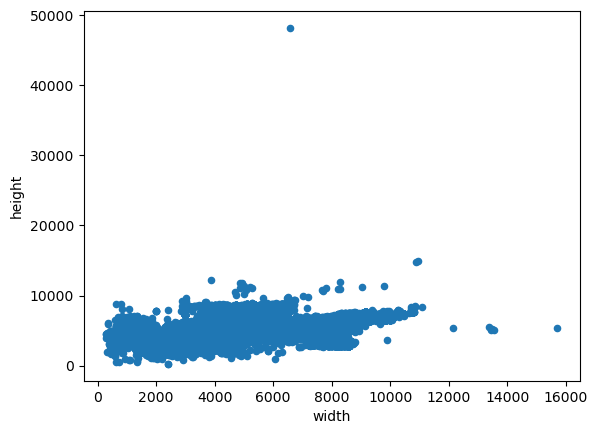

In [17]:
df_images.plot.scatter(x = "width", y = "height")

/home/stutzmann/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Axes: xlabel='Image_width', ylabel='Image_height'>

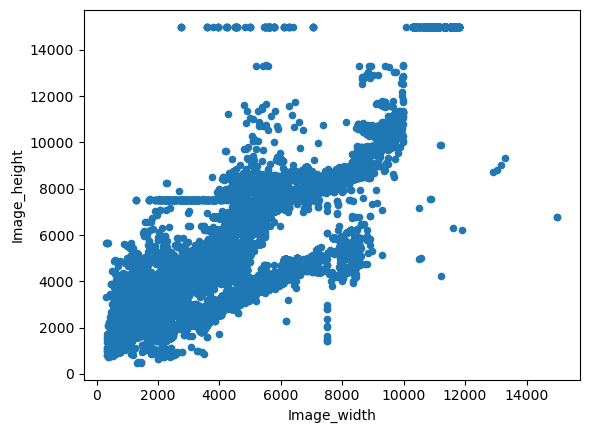

In [33]:
df_pages.plot.scatter(x = "Image_width", y = "Image_height")

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


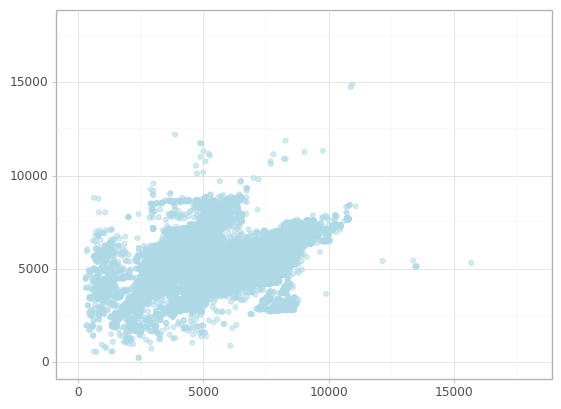

<ggplot: (8732532577175)>

In [18]:
o = (ggplot(df_images, aes(x = "width", y = "height"))
    + geom_point(color='lightblue', alpha=0.5)
     + theme_light()
     + xlim(0,18000)
     + ylim(0,18000)
  + labs(x=None,y=None)
)
o

# + stat_density_2d(aes(fill=after_stat('density')), geom='raster', contour=False, levels=10)
#  + scale_fill_gradient2(low = "white", high = "red", midpoint = 0.5e-9) # mid = "#1A6AFF", 
 

In [21]:
q = (ggplot(df_images, aes(x = "width", y = "height"))
    + theme_light()
    + labs(x=None,y=None)
     + geom_point(color='black', size=0.1) # alpha=0.5
     + stat_density_2d(aes(fill=after_stat('density')), geom='raster', contour=False, levels=0)
    + scale_fill_gradientn(colors = ("white", "lightgreen", "blue", "red"), alpha=0.01) #scale_fill_gradient2(low = "white", high = "red", midpoint = 0.5e-9) # mid = "#1A6AFF", 
     
  )

r = (ggplot(df_images, aes(x = "width", y = "height"))
    + theme_light()
    + labs(x=None,y=None)
     + stat_density_2d(aes(fill=after_stat('density')), geom='raster', contour=False, levels=0)
    + scale_fill_gradientn(colors = ("white", "lightgreen", "blue", "red"), alpha=0.01) #scale_fill_gradient2(low = "white", high = "red", midpoint = 0.5e-9) # mid = "#1A6AFF", 
    + geom_point(color='blue', size=0.1, alpha=0.01)
     
  )


/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_fill_gradientn could not recognise parameter `alpha`


In [22]:
ggsave(plot=q, filename='image_sizes_density_home.png', dpi=1000)
ggsave(plot=r, filename='image_sizes_scatter_home.png', dpi=1000)

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: image_sizes_density_home.png
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: image_sizes_scatter_home.png


## Images : sur un volume

In [26]:
vol_id = '0c547050-da4d-4708-adca-779a46c73e27'
vol_pages = df_pages[df_pages['Volume_id'] == vol_id]
vol_name = vol_pages.iat[0,0]
print(vol_name)
print(vol_pages.shape)
print(vol_pages.head())

États-Unis, Baltimore, The Walters Art Museum, W.0169
(407, 11)
                                             Volume_name  \
16377  États-Unis, Baltimore, The Walters Art Museum,...   
16378  États-Unis, Baltimore, The Walters Art Museum,...   
16379  États-Unis, Baltimore, The Walters Art Museum,...   
16380  États-Unis, Baltimore, The Walters Art Museum,...   
16381  États-Unis, Baltimore, The Walters Art Museum,...   

                                  Volume_id  \
16377  0c547050-da4d-4708-adca-779a46c73e27   
16378  0c547050-da4d-4708-adca-779a46c73e27   
16379  0c547050-da4d-4708-adca-779a46c73e27   
16380  0c547050-da4d-4708-adca-779a46c73e27   
16381  0c547050-da4d-4708-adca-779a46c73e27   

                                    Page_id  Page_order  \
16377  00b44a24-5ea0-42bf-b511-16735ae43509          52   
16378  00c90c51-d15f-43fb-beb9-41a608953a07         160   
16379  014483db-f6ac-4581-bbce-0a53a0b2571a         260   
16380  01532cad-4c46-47bd-b101-2ce965cd4b77         161 

<Axes: xlabel='Image_width', ylabel='Image_height'>

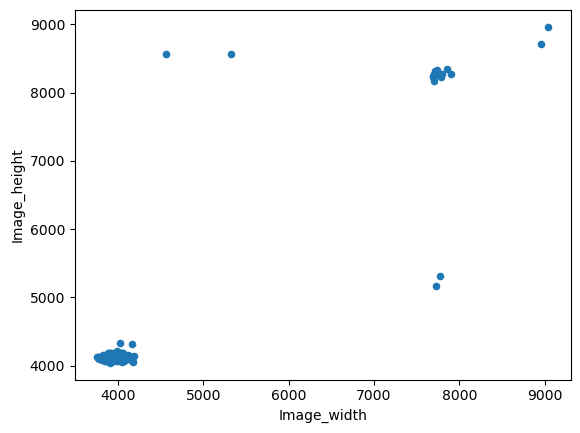

In [29]:
a = vol_pages.plot.scatter(x = "Image_width", y = "Image_height")
plt.savefig(f'image_sizes_{vol_name}.png')
a

In [10]:
print(vol_pages.iat[0,7])

74c7f1ae-7e5c-4804-9bdc-6fee29e3b993


In [17]:
vol_pages_max = vol_pages[vol_pages['Image_height'] > 5000]
print(vol_pages_max.shape)
print(vol_pages_max.head())

(19, 11)
                                             Volume_name  \
16384  États-Unis, Baltimore, The Walters Art Museum,...   
16389  États-Unis, Baltimore, The Walters Art Museum,...   
16409  États-Unis, Baltimore, The Walters Art Museum,...   
16413  États-Unis, Baltimore, The Walters Art Museum,...   
16474  États-Unis, Baltimore, The Walters Art Museum,...   

                                  Volume_id  \
16384  0c547050-da4d-4708-adca-779a46c73e27   
16389  0c547050-da4d-4708-adca-779a46c73e27   
16409  0c547050-da4d-4708-adca-779a46c73e27   
16413  0c547050-da4d-4708-adca-779a46c73e27   
16474  0c547050-da4d-4708-adca-779a46c73e27   

                                    Page_id  Page_order  \
16384  03fbc0de-5082-4e22-8482-2884816192a4         107   
16389  061e4f1e-764e-4084-99de-955184b0e932         275   
16409  0dfbfdc2-99e7-4e2f-9729-275035a05a69           0   
16413  12d49469-ab84-47c6-a116-1cbdee556266         404   
16474  392a3a35-8158-4130-b83e-ef5b209a6ce2         

In [18]:
len(vol_pages_max)

19

In [20]:
for i in range(len(vol_pages_max)):
    print(vol_pages_max.iat[i,8] + "/full/600,/0/default.jpg")

https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000108_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000276_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000001_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000405_965/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000403_989/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000264_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000286_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000184_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000406_965/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_000076_1200/full/600,/0/default.jpg
https://stacks.stanford.edu/image/iiif/vj053mn4619%2FW169_00040

# Statistiques descriptives et traitement lignes

In [17]:
print(df_lines.shape)
print(df_lines.head())

(6573148, 12)
                                         Volume_name  \
0  France, Paris, Bibliothèque nationale de Franc...   
1  France, Paris, Bibliothèque nationale de Franc...   
2  France, Paris, Bibliothèque nationale de Franc...   
3  France, Paris, Bibliothèque nationale de Franc...   
4  France, Paris, Bibliothèque nationale de Franc...   

                              Volume_id  Page_order  \
0  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
1  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
2  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
3  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
4  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   

                                Page_id Page_name  \
0  00010adc-f971-40bb-8416-07e134786b18        NP   
1  00010adc-f971-40bb-8416-07e134786b18        NP   
2  00010adc-f971-40bb-8416-07e134786b18        NP   
3  00010adc-f971-40bb-8416-07e134786b18        NP   
4  00010adc-f971-40bb-8416-07e134786b18        NP   


## 1 (bis). Sélectionner un volume

In [113]:
vol = df_lines[df_lines['Volume_id'] == '0c547050-da4d-4708-adca-779a46c73e27']
# vol = df[df['Volume_id'] == 'c826e317-b7cc-4836-b096-36406274f904']
print(vol.shape)
print(vol.head())

(6779, 12)
                                             Volume_name  \
18881  États-Unis, Baltimore, The Walters Art Museum,...   
18882  États-Unis, Baltimore, The Walters Art Museum,...   
18883  États-Unis, Baltimore, The Walters Art Museum,...   
18884  États-Unis, Baltimore, The Walters Art Museum,...   
18885  États-Unis, Baltimore, The Walters Art Museum,...   

                                  Volume_id  Page_order  \
18881  0c547050-da4d-4708-adca-779a46c73e27          52   
18882  0c547050-da4d-4708-adca-779a46c73e27          52   
18883  0c547050-da4d-4708-adca-779a46c73e27          52   
18884  0c547050-da4d-4708-adca-779a46c73e27          52   
18885  0c547050-da4d-4708-adca-779a46c73e27          52   

                                    Page_id Page_name  \
18881  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18882  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18883  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18884  00b44a24-5ea0-42bf-b511-16735ae43509  

### test

In [41]:
test = df_lines[df_lines['Volume_id'] == '09b97bee-e4fc-4fca-958e-3785af22e44b']

In [44]:
'''for i in range(len(test)):
   print(test.iat[i, 2], test.iat[i, 3], test.iat[i, 4], test.iat[i, 5])
   '''
test.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,Image_id,Line_id,Line_name,Line_polygon,Line_type,Line_order
29082,"États-Unis, Baltimore, The Walters Art Museum,...",09b97bee-e4fc-4fca-958e-3785af22e44b,222,01192a5e-5de2-42c4-b0a2-f251362425ef,Page 223,"[[0, 0], [0, 9247], [8480, 9247], [8480, 0], [...",b357955e-dfd4-4142-8aff-ce2c7522e90b,0053871b-4f6d-47bf-9759-b713b396c06c,16,"[[141, 7015], [146, 7105], [663, 7078], [659, ...",text_line,15
29083,"États-Unis, Baltimore, The Walters Art Museum,...",09b97bee-e4fc-4fca-958e-3785af22e44b,222,01192a5e-5de2-42c4-b0a2-f251362425ef,Page 223,"[[0, 0], [0, 9247], [8480, 9247], [8480, 0], [...",b357955e-dfd4-4142-8aff-ce2c7522e90b,07431340-3e76-445e-acd7-dfdc928e549d,12,"[[133, 5900], [133, 6020], [421, 6020], [421, ...",text_line,11
29084,"États-Unis, Baltimore, The Walters Art Museum,...",09b97bee-e4fc-4fca-958e-3785af22e44b,222,01192a5e-5de2-42c4-b0a2-f251362425ef,Page 223,"[[0, 0], [0, 9247], [8480, 9247], [8480, 0], [...",b357955e-dfd4-4142-8aff-ce2c7522e90b,0c0a6f13-2d27-4afd-be1c-3f615731df09,9,"[[4180, 5647], [4180, 5707], [4613, 5707], [46...",text_line,8
29085,"États-Unis, Baltimore, The Walters Art Museum,...",09b97bee-e4fc-4fca-958e-3785af22e44b,222,01192a5e-5de2-42c4-b0a2-f251362425ef,Page 223,"[[0, 0], [0, 9247], [8480, 9247], [8480, 0], [...",b357955e-dfd4-4142-8aff-ce2c7522e90b,3e5038bc-f60e-4434-80f0-84e3144ea840,7,"[[771, 5418], [771, 5465], [1072, 5465], [1072...",text_line,6
29086,"États-Unis, Baltimore, The Walters Art Museum,...",09b97bee-e4fc-4fca-958e-3785af22e44b,222,01192a5e-5de2-42c4-b0a2-f251362425ef,Page 223,"[[0, 0], [0, 9247], [8480, 9247], [8480, 0], [...",b357955e-dfd4-4142-8aff-ce2c7522e90b,5fd09043-be5f-4dea-a4cf-4251fefaa08c,13,"[[554, 6031], [3841, 6048], [3842, 5917], [555...",text_line,12


In [43]:
test_2 = np.unique(test['Page_polygon']) 
test_2

array(['[[0, 0], [0, 4482], [4374, 4482], [4374, 0], [0, 0]]',
       '[[0, 0], [0, 4482], [4380, 4482], [4380, 0], [0, 0]]',
       '[[0, 0], [0, 4487], [4390, 4487], [4390, 0], [0, 0]]',
       '[[0, 0], [0, 4503], [4369, 4503], [4369, 0], [0, 0]]',
       '[[0, 0], [0, 4508], [4379, 4508], [4379, 0], [0, 0]]',
       '[[0, 0], [0, 4524], [4322, 4524], [4322, 0], [0, 0]]',
       '[[0, 0], [0, 4529], [4401, 4529], [4401, 0], [0, 0]]',
       '[[0, 0], [0, 4539], [4390, 4539], [4390, 0], [0, 0]]',
       '[[0, 0], [0, 4540], [4447, 4540], [4447, 0], [0, 0]]',
       '[[0, 0], [0, 4544], [4202, 4544], [4202, 0], [0, 0]]',
       '[[0, 0], [0, 4550], [4521, 4550], [4521, 0], [0, 0]]',
       '[[0, 0], [0, 4555], [4218, 4555], [4218, 0], [0, 0]]',
       '[[0, 0], [0, 4555], [4312, 4555], [4312, 0], [0, 0]]',
       '[[0, 0], [0, 4560], [4412, 4560], [4412, 0], [0, 0]]',
       '[[0, 0], [0, 4560], [4417, 4560], [4417, 0], [0, 0]]',
       '[[0, 0], [0, 4566], [4187, 4566], [4187, 0], [0

In [31]:
page_polygons = test_2.tolist()
for k in range(len(page_polygons)):
        page_polygons[k] = eval(page_polygons[k])
        page_polygons[k] = extrema_np(page_polygons[k])
# print(type(page_polygons))
print(page_polygons)
page_x = max(page_polygons)[0]
page_y = max(page_polygons)[2]
print("max width : ", page_x, " ; max height : ", page_y)


[(5600, 0, 3936, 0), (5664, 0, 3968, 0), (5696, 0, 4000, 0), (5984, 0, 4000, 0), (5664, 0, 4032, 0), (5728, 0, 4032, 0), (5856, 0, 4064, 0), (5984, 0, 4064, 0), (5824, 0, 4096, 0), (5728, 0, 4128, 0), (5824, 0, 4128, 0), (5920, 0, 4128, 0), (6080, 0, 4128, 0), (6016, 0, 4160, 0), (5888, 0, 4192, 0), (5824, 0, 4224, 0), (5856, 0, 4224, 0), (5888, 0, 4224, 0), (6272, 0, 4224, 0), (5952, 0, 4384, 0), (6432, 0, 4384, 0), (6112, 0, 4544, 0), (6880, 0, 4608, 0)]
max width :  6880  ; max height :  4608


## 2. Traiter l'information des coordonnées de lignes

### 2.1. Transformer les coordonnnées du polygone en liste

In [10]:
# Transformation des données 'string' décrivant le polygone en liste de listes où chaque point est une liste [x,y]
lines = list(vol['Line_polygon'])
for i in range(len(vol)):
    lines[i] = eval(lines[i])

lines[0][0][0] #test que le format est bon

2612

### 2.2. Une fonction qui réduit un polygone à un rectangle

In [7]:
# Source : https://stackoverflow.com/questions/59581469/find-min-max-by-index-in-list-of-lists
# il y a des fonctions plus rapides
# à partir d'une liste, retourne un tuple (x1, y1, x2, y2)

def extrema_np(items):
    arr = np.array(items)
    return np.min(arr[:, 0]), np.min(arr[:, 1]), np.max(arr[:, 0]), np.max(arr[:, 1])

In [8]:
# Réduction de polygone à rectangle. Chaque ligne est décrite par un tuple de quatre entiers

for i in range(len(lines)):
    lines[i] = extrema_np(lines[i])



NameError: name 'lines' is not defined

In [13]:
# Vérifier le type des variables
print(len(lines))
print(type(lines))
print(type(lines[1]))
print(type(lines[1][0]))
print(lines[:5])

3514
<class 'list'>
<class 'tuple'>
<class 'numpy.int64'>
[(2612, 1227, 3714, 1301), (2606, 1871, 3660, 1938), (2834, 1663, 3674, 1730), (2787, 1771, 3687, 1838), (2612, 704, 3647, 778)]


## 3. Créer un masque avec les lignes

### 3.1. Sur une ligne

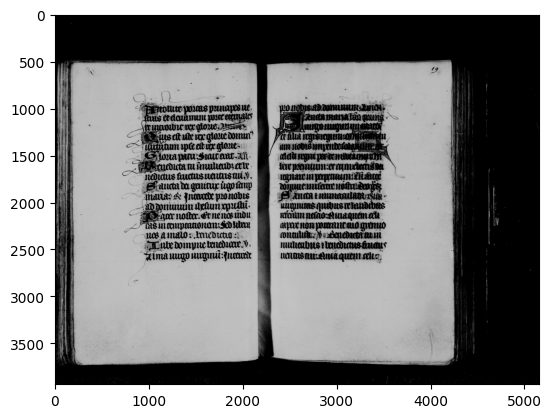

In [14]:
# Import d'une image du volume pour avoir les dimensions

img = cv2.imread("test3.jpg")
import matplotlib.pyplot as plt
# load the image
plt.imshow(img)

In [ ]:
# https://stackoverflow.com/questions/56472024/how-to-change-the-opacity-of-boxes-cv2-rectangle

# import cv2
# import numpy as np

img = cv2.imread("test3.jpg")

# On crée un masque noir
mask1 = np.zeros_like(img[:,:,0])
# plt.imshow(mask1)

# On étudie uniquement la première ligne décrite
i = 1
print(lines[i])

# First we crop the sub-rect from the image
x1, y1, x2, y2 = int(lines[i][0]), int(lines[i][1]), int(lines[i][2]), int(lines[i][3])
print(x1, y1, x2, y2)

# We extract a black patch of the size of the line
sub_img = mask1[y1:y2, x1:x2]

# We create a white patch of the size of the line
white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255

# We create a mix of both with transparency
res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)

# Putting the image back to its position
mask1[y1:y2, x1:x2] = res

plt.imshow(mask1)
plt.savefig(fname='test_transparent.png', dpi=300, format='png', transparent=False)


### 3.2. Sur l'ensemble des lignes

In [ ]:
# https://stackoverflow.com/questions/56472024/how-to-change-the-opacity-of-boxes-cv2-rectangle

img = cv2.imread("test3.jpg")

# On crée un masque noir
mask1 = np.zeros_like(img[:,:,0])
# plt.imshow(mask1)

for i in range(len(lines)):
    x1, y1, x2, y2 = int(lines[i][0]), int(lines[i][1]), int(lines[i][2]), int(lines[i][3])
    # print(x1, y1, x2, y2)
    # We extract a black patch of the size of the line
    sub_img = mask1[y1:y2, x1:x2]
    # We create a white patch of the size of the line
    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
    # We create a mix of both with transparency
    res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
    # Putting the image back to its position
    mask1[y1:y2, x1:x2] = res

plt.imshow(mask1)
plt.savefig(fname='test_transparent2.png', dpi=300, format='png', transparent=False)


### 3.3 Raccourci pour un volume
Traite un volume en entier et donne l'identifiant des éléments Page(s) et Image(s) qui donnent les coordonnées extrêmes

                                             Volume_name  \
18881  États-Unis, Baltimore, The Walters Art Museum,...   
18882  États-Unis, Baltimore, The Walters Art Museum,...   
18883  États-Unis, Baltimore, The Walters Art Museum,...   
18884  États-Unis, Baltimore, The Walters Art Museum,...   
18885  États-Unis, Baltimore, The Walters Art Museum,...   

                                  Volume_id  Page_order  \
18881  0c547050-da4d-4708-adca-779a46c73e27          52   
18882  0c547050-da4d-4708-adca-779a46c73e27          52   
18883  0c547050-da4d-4708-adca-779a46c73e27          52   
18884  0c547050-da4d-4708-adca-779a46c73e27          52   
18885  0c547050-da4d-4708-adca-779a46c73e27          52   

                                    Page_id Page_name  \
18881  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18882  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18883  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   
18884  00b44a24-5ea0-42bf-b511-16735ae43509   Page 53   

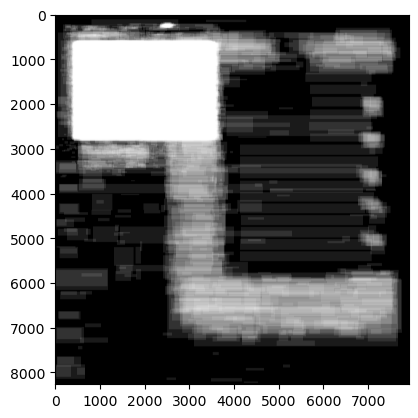

In [32]:
# Code repris de ci-dessous et simplifié pour correspondre à la requête sur un seul volume

vol_id = '0c547050-da4d-4708-adca-779a46c73e27'

vol = df_lines[df_lines['Volume_id'] == vol_id]
print(vol.head())

# Find maximal size of images
page_polygons = np.unique(vol['Page_polygon'])  # type = np.array
page_polygons = page_polygons.tolist()
for k in range(len(page_polygons)):
    page_polygons[k] = eval(page_polygons[k])
    page_polygons[k] = extrema_np(page_polygons[k])
    # print(type(page_polygons))
    
page_x = max(page_polygons)[2]
page_y = max(page_polygons)[3]
print(page_x, page_y)

for l in range(len(vol)):
    if (str(page_x) or str(page_y)) in vol.iloc[l,5]:
        print(vol.iloc[l,3:6])
    
    
    
#create mask and lines
mask1 = np.zeros((page_y,page_x,3), np.uint8)
lines = list(vol['Line_polygon'])
for i in range(len(vol)):
    lines[i] = eval(lines[i])
    lines[i] = extrema_np(lines[i])
    # plt.imshow(mask1)
for i in range(len(lines)):
    x1, y1, x2, y2 = int(lines[i][0]), int(lines[i][1]), int(lines[i][2]), int(lines[i][3])
    # We extract a black patch of the size of the line
    sub_img = mask1[y1:y2, x1:x2]
    # We create a white patch of the size of the line
    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
    # We create a mix of both with transparency
    res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
    # Putting the image back to its position
    mask1[y1:y2, x1:x2] = res
    
image_name = vol_id + '.png'
print(image_name)
plt.imshow(mask1)
plt.savefig(fname=image_name, dpi=300, format='png', transparent=False)
    


## 4. Faire la même chose pour tous les volumes

In [10]:
df_lines.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,Image_id,Line_id,Line_name,Line_polygon,Line_type,Line_order
0,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",1be67795-5ac6-4722-b7f7-94f397a82005,0c02ce87-aa79-47ed-a7ee-be0ae5ea9a76,22,"[[2640, 1764], [2640, 1765], [2640, 1766], [26...",text_line,21
1,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",1be67795-5ac6-4722-b7f7-94f397a82005,160a5b07-9cb8-4da3-bc75-a8056b867e5f,2,"[[2640, 839], [2640, 840], [2640, 841], [2640,...",text_line,1
2,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",1be67795-5ac6-4722-b7f7-94f397a82005,184e55e3-8d29-48d2-ad1d-25bf6025173a,7,"[[1339, 1145], [1339, 1146], [1339, 1147], [13...",text_line,6
3,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",1be67795-5ac6-4722-b7f7-94f397a82005,22b10041-e14f-402d-8827-aba2e8f270b6,11,"[[1339, 1325], [1339, 1326], [1339, 1327], [13...",text_line,10
4,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",1be67795-5ac6-4722-b7f7-94f397a82005,28d8eff1-5583-4e4f-8d70-4caaf42a1e2e,13,"[[1345, 1380], [1345, 1381], [1345, 1382], [13...",text_line,12


In [11]:
vols = np.unique(df_lines['Volume_id'])

In [46]:
print(type(vols))
print(len(vols))
print(vols)
print(vols[0])

<class 'numpy.ndarray'>
1158
['000e5d6d-c163-40b5-8d18-0e211b46f26e'
 '001f1a10-1483-4c22-8e0d-c6a0f06d58f2'
 '003d5be0-3453-46e9-b904-4f6d4f1ee4b5' ...
 'ff5abf5d-527f-4db5-9ae0-51222fe71a78'
 'ff9f0d4f-a8ea-49c4-af3d-5524475cbf5e'
 'ffeff08f-5b12-4284-8ec9-71371714b869']
000e5d6d-c163-40b5-8d18-0e211b46f26e


In [ ]:
'''
page_polygons = test_2.tolist()
for k in range(len(page_polygons)):
        page_polygons[k] = eval(page_polygons[k])
        page_polygons[k] = extrema_np(page_polygons[k])
# print(type(page_polygons))
print(page_polygons)
page_x = max(page_polygons)[0]
page_y = max(page_polygons)[2]
print("max width : ", page_x, " ; max height : ", page_y)

'''
# %%time
# pd.set_option('display.max_colwidth', 100)
for j in range(len(vols)):
#for j in range(52,53):
    print(j, vols[j])
    vol = df_lines[df_lines['Volume_id'] == vols[j]]
    # vol = df_lines[df_lines['Volume_id'] == '000e5d6d-c163-40b5-8d18-0e211b46f26e']
    # vol = df_lines[df_lines['Volume_id'] == '0077afea-4545-4197-bb26-f0e667ff1e4a']
    # print(vols[j])
    # on doit créer un masque spécifique par volume
    # après un premier essai, avec  arbitrairement la taille de la première image, on revient à "refuse the temptation to guess". Souvent c'est une image spécifique, plus petite (photo de la reliure, ou mire couleur)
    page_polygons = np.unique(vol['Page_polygon'])  # type = np.array
    page_polygons = page_polygons.tolist()
    # print(page_polygons)
    for k in range(len(page_polygons)):
        page_polygons[k] = eval(page_polygons[k])
        page_polygons[k] = extrema_np(page_polygons[k])
    # print(type(page_polygons))
    # print(page_polygons)
    page_x = max(page_polygons)[0]
    page_y = max(page_polygons)[2]
    print("max width : ", page_x, " ; max height : ", page_y)

    mask1 = np.zeros((page_y,page_x,3), np.uint8)
    lines = list(vol['Line_polygon'])
    for i in range(len(vol)):
        lines[i] = eval(lines[i])
        lines[i] = extrema_np(lines[i])
        # print(lines[i])
        # plt.imshow(mask1)
    for i in range(len(lines)):
        if (lines[i][1] is None or lines[i][3] is None or lines[i][0] is None or lines[i][2] is None):
            print(lines[i])
        else:
            x1, y1, x2, y2 = int(lines[i][1]), int(lines[i][3]), int(lines[i][0]), int(lines[i][2])
            if (x2 > page_x) or (y2 > page_y):
                # print("lines outside page", x1, x2, y1, y2, page_x, page_y)
                pass
            # We extract a black patch of the size of the line
            # On some lines, there was an error stating that int() cannot work on NoneType. Not checked were the data is faulty, but it is !!!!!!!!!
            # TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'
            else:
                sub_img = mask1[y1:y2, x1:x2]
                # We create a white patch of the size of the line
                white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
                # We create a mix of both with transparency
                res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
                # Putting the image back to its position
                mask1[y1:y2, x1:x2] = res
    
    
    image_name = f'HoraeVolImages/{vols[j].replace("/", "_")}.png'
    print(image_name)
    plt.imshow(mask1)
    plt.savefig(fname=image_name, dpi=300, format='png', transparent=False)
    plt.close('all')    

    

0 000e5d6d-c163-40b5-8d18-0e211b46f26e
max width :  2744  ; max height :  3824
HoraeVolImages/000e5d6d-c163-40b5-8d18-0e211b46f26e.png
1 001f1a10-1483-4c22-8e0d-c6a0f06d58f2
max width :  1998  ; max height :  2823
HoraeVolImages/001f1a10-1483-4c22-8e0d-c6a0f06d58f2.png
2 003d5be0-3453-46e9-b904-4f6d4f1ee4b5
max width :  6838  ; max height :  4881
HoraeVolImages/003d5be0-3453-46e9-b904-4f6d4f1ee4b5.png
3 00483b65-7a07-4e00-abdc-db8f5922d957
max width :  1775  ; max height :  2623
HoraeVolImages/00483b65-7a07-4e00-abdc-db8f5922d957.png
4 0068e751-c249-4d8b-82f6-07933fe0cecd
max width :  3091  ; max height :  4270
HoraeVolImages/0068e751-c249-4d8b-82f6-07933fe0cecd.png
5 0077afea-4545-4197-bb26-f0e667ff1e4a
max width :  6059  ; max height :  7501
HoraeVolImages/0077afea-4545-4197-bb26-f0e667ff1e4a.png
6 009c37f0-618a-4d58-b81a-511a36fa0fac
max width :  2936  ; max height :  2077
HoraeVolImages/009c37f0-618a-4d58-b81a-511a36fa0fac.png
7 00c496c6-dff1-405b-8a6c-978063c66ac0
max width :  225

# Pages, avec compte et ids des miniatures, lignes, singlePages, paragraphes

In [7]:
# vérifier si le dataframe est bien présent
print(df_Pages.shape)
print(df_Pages.head())

(513800, 23)
                                    Volume_name  \
0  Archives départementales du Calvados, H 7745   
1  Archives départementales du Calvados, H 7745   
2  Archives départementales du Calvados, H 7745   
3  Archives départementales du Calvados, H 7745   
4  Archives départementales du Calvados, H 7745   

                              Volume_id                               Page_id  \
0  0009b524-fda6-412b-9165-5c7ecfc0e146  028ec3ea-7912-4632-8173-b25c70b17a0a   
1  0009b524-fda6-412b-9165-5c7ecfc0e146  0417cea5-a3cc-4056-bc40-3cb880612da1   
2  0009b524-fda6-412b-9165-5c7ecfc0e146  057bc2dc-c356-41e4-a837-c9b453ddcdee   
3  0009b524-fda6-412b-9165-5c7ecfc0e146  062ed2cd-5120-42cd-b843-7869a4c6601c   
4  0009b524-fda6-412b-9165-5c7ecfc0e146  0735ff20-02ee-490c-af2c-ecc9aaa54843   

   Page_order                                       Page_polygon Page_name  \
0          72  [[0, 0], [0, 5544], [7832, 5544], [7832, 0], [...        f.   
1          55  [[0, 0], [0, 5080], [7

In [8]:
MiniatureByPage = df_Pages.groupby('NbMiniatures')[['Page_id']].nunique()
#pageImageByVolume.sort_values('Page_id').plot()
MiniatureByPage

,Page_id
NbMiniatures,
0,513800


## Volume

In [24]:
vol_id = '831dbc58-f71b-4656-9b26-7f58dd254ec4'
vol_pages = df_Pages[df_Pages['Volume_id'] == vol_id]
vol_name = vol_pages.iat[0,0]
print(vol_name)
print(vol_pages.shape)
print(vol_pages.head())

France, Paris, Bibliothèque nationale de France, Bibliothèque de l'Arsenal, 616
(348, 23)
                                              Volume_name  \
147192  France, Paris, Bibliothèque nationale de Franc...   
147193  France, Paris, Bibliothèque nationale de Franc...   
147194  France, Paris, Bibliothèque nationale de Franc...   
147195  France, Paris, Bibliothèque nationale de Franc...   
147196  France, Paris, Bibliothèque nationale de Franc...   

                                   Volume_id  \
147192  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147193  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147194  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147195  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147196  831dbc58-f71b-4656-9b26-7f58dd254ec4   

                                     Page_id  Page_order  \
147192  00ee9f10-db5c-4fe3-816f-56b8e495c8ff          54   
147193  0299da27-18f1-4126-bc1f-b158bad2d43e         235   
147194  03cb72a9-760c-4ac2-9210-f44ea9c8d26e         211   
147195  03d462

In [73]:
MiniatureByPage = vol_pages.groupby('NbMiniatures')[['Page_id']].nunique()
#pageImageByVolume.sort_values('Page_id').plot()
MiniatureByPage

,Page_id
NbMiniatures,
0.0,290
1.0,58


In [74]:
vol_pages = vol_pages.sort_values('Page_order')

In [75]:
vol_pages.head()

,Volume_name,Volume_id,Page_id,Page_order,Page_polygon,Page_name,Image_id,NbMiniatures,NbLines,Image_id2,Image_url,Image_width,Image_height
147364,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,83b699eb-2032-4014-af3c-be0f2996a148,0,"[[0, 0], [0, 4077], [3071, 4077], [3071, 0], [...",plat sup,86305b08-6a3e-4b93-ae90-2aba69f4f286,0.0,0.0,86305b08-6a3e-4b93-ae90-2aba69f4f286,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,3071,4077
147262,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,372c9789-9992-4692-a6fd-ff43f7e9faf5,1,"[[0, 0], [0, 4069], [2902, 4069], [2902, 0], [...",contreplat sup,9947f448-cef3-4db2-9417-1c99ebbe2d72,0.0,4.0,9947f448-cef3-4db2-9417-1c99ebbe2d72,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2902,4069
147427,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,b3515350-aad6-45f4-b592-de05286ea000,2,"[[0, 0], [0, 3935], [2813, 3935], [2813, 0], [...",page de garde recto,70eaac26-b5fb-4ebf-b127-078757ff8837,0.0,5.0,70eaac26-b5fb-4ebf-b127-078757ff8837,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2813,3935
147358,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,7db9ee18-97c2-41cf-b252-12cb2b7cc9e5,3,"[[0, 0], [0, 3914], [2801, 3914], [2801, 0], [...",page de garde verso,84f399c6-c9b7-4c0c-889d-993718cf430c,0.0,0.0,84f399c6-c9b7-4c0c-889d-993718cf430c,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2801,3914
147226,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,1a8ea2b8-ad67-4355-804f-70c6c00b0265,4,"[[0, 0], [0, 3913], [2831, 3913], [2831, 0], [...",page de garde recto,7893a46e-d653-481f-b64c-9d23ee10913b,0.0,4.0,7893a46e-d653-481f-b64c-9d23ee10913b,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2831,3913


In [76]:
vol_pages.reset_index(inplace=True)
vol_pages.head()

,index,Volume_name,Volume_id,Page_id,Page_order,Page_polygon,Page_name,Image_id,NbMiniatures,NbLines,Image_id2,Image_url,Image_width,Image_height
0,147364,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,83b699eb-2032-4014-af3c-be0f2996a148,0,"[[0, 0], [0, 4077], [3071, 4077], [3071, 0], [...",plat sup,86305b08-6a3e-4b93-ae90-2aba69f4f286,0.0,0.0,86305b08-6a3e-4b93-ae90-2aba69f4f286,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,3071,4077
1,147262,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,372c9789-9992-4692-a6fd-ff43f7e9faf5,1,"[[0, 0], [0, 4069], [2902, 4069], [2902, 0], [...",contreplat sup,9947f448-cef3-4db2-9417-1c99ebbe2d72,0.0,4.0,9947f448-cef3-4db2-9417-1c99ebbe2d72,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2902,4069
2,147427,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,b3515350-aad6-45f4-b592-de05286ea000,2,"[[0, 0], [0, 3935], [2813, 3935], [2813, 0], [...",page de garde recto,70eaac26-b5fb-4ebf-b127-078757ff8837,0.0,5.0,70eaac26-b5fb-4ebf-b127-078757ff8837,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2813,3935
3,147358,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,7db9ee18-97c2-41cf-b252-12cb2b7cc9e5,3,"[[0, 0], [0, 3914], [2801, 3914], [2801, 0], [...",page de garde verso,84f399c6-c9b7-4c0c-889d-993718cf430c,0.0,0.0,84f399c6-c9b7-4c0c-889d-993718cf430c,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2801,3914
4,147226,"France, Paris, Bibliothèque nationale de Franc...",831dbc58-f71b-4656-9b26-7f58dd254ec4,1a8ea2b8-ad67-4355-804f-70c6c00b0265,4,"[[0, 0], [0, 3913], [2831, 3913], [2831, 0], [...",page de garde recto,7893a46e-d653-481f-b64c-9d23ee10913b,0.0,4.0,7893a46e-d653-481f-b64c-9d23ee10913b,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,2831,3913


<Axes: xlabel='Page_order'>

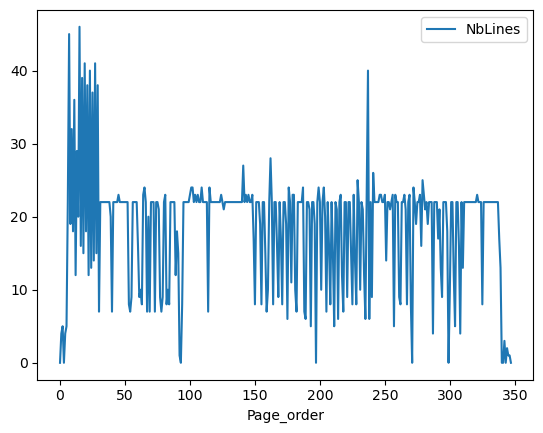

In [77]:
vol_pages.plot(x='Page_order', y='NbLines')

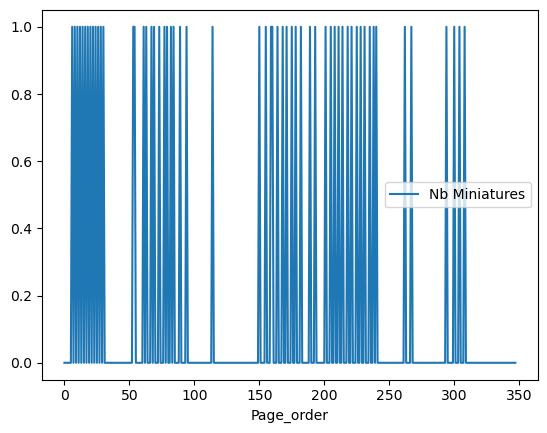

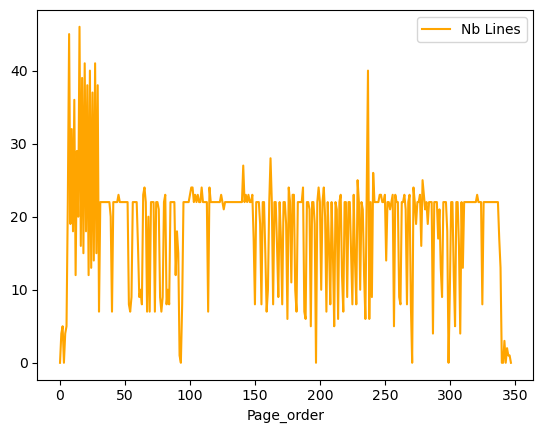

In [78]:
vol_pages.plot(x='Page_order', y='NbMiniatures', label="Nb Miniatures")
vol_pages.plot(x='Page_order', y='NbLines', label="Nb Lines", color="orange")

#display plot
plt.show()

<Figure size 2000x600 with 0 Axes>

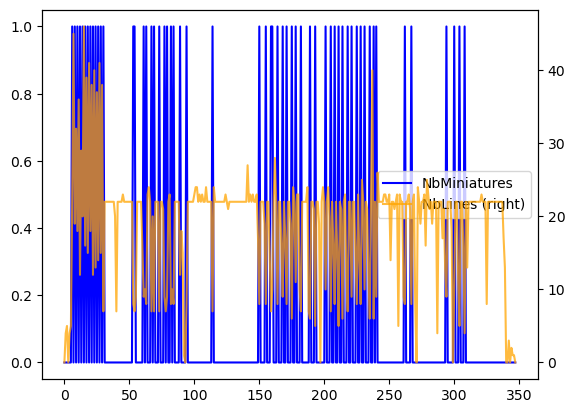

In [79]:
# vol_pages.plot(x='Page_order', y='NbMiniatures', label="Nb Miniatures")
# vol_pages.plot(x='Page_order', y='NbLines', label="Nb Lines", color="orange")
# Source of code: # SOURCE : https://towardsdatascience.com/creating-a-dual-axis-combo-chart-in-python-52624b187834
plt.figure(figsize=(20,6))

# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
vol_pages.plot(
    use_index=True, 
    kind='line',
    y='NbMiniatures', 
    ax=ax, 
    color='blue'
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
vol_pages.plot(
    use_index=True, 
    y='NbLines', 
    ax=ax, 
    secondary_y=True, 
    color='orange', 
    alpha=0.75
)
plt.savefig(f'nb_Miniatures_Lines_{vol_name}.png', dpi=300)
plt.show()

<Axes: xlabel='NbLines', ylabel='Volume_id'>

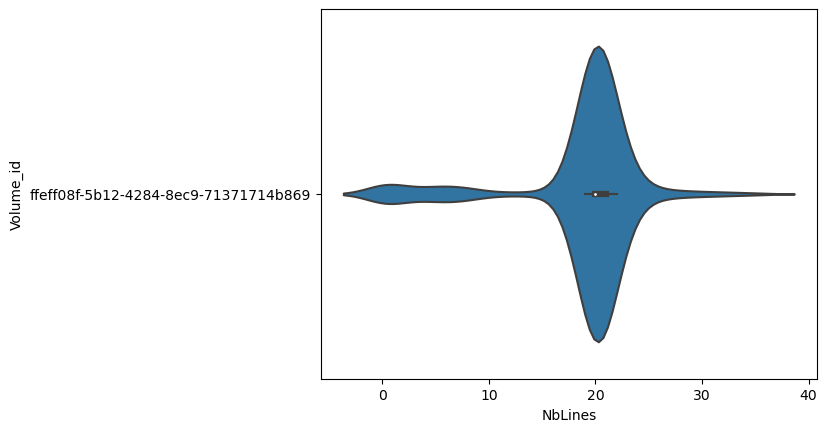

In [96]:
sns.violinplot(y=vol_pages["Volume_id"], x=vol_pages["NbLines"])

### Créer un masque avec les lignes

In [25]:
print(vol_pages.head())

                                              Volume_name  \
147192  France, Paris, Bibliothèque nationale de Franc...   
147193  France, Paris, Bibliothèque nationale de Franc...   
147194  France, Paris, Bibliothèque nationale de Franc...   
147195  France, Paris, Bibliothèque nationale de Franc...   
147196  France, Paris, Bibliothèque nationale de Franc...   

                                   Volume_id  \
147192  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147193  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147194  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147195  831dbc58-f71b-4656-9b26-7f58dd254ec4   
147196  831dbc58-f71b-4656-9b26-7f58dd254ec4   

                                     Page_id  Page_order  \
147192  00ee9f10-db5c-4fe3-816f-56b8e495c8ff          54   
147193  0299da27-18f1-4126-bc1f-b158bad2d43e         235   
147194  03cb72a9-760c-4ac2-9210-f44ea9c8d26e         211   
147195  03d4626b-a2a5-433c-91ba-5d57a7a3d22c         144   
147196  056d6bd5-af0b-4bf9-af0a-f420418a8773

France, Paris, Bibliothèque nationale de France, Bibliothèque de l'Arsenal, 616
3071 4114
831dbc58-f71b-4656-9b26-7f58dd254ec4.png


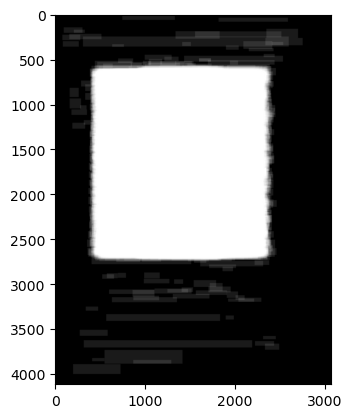

In [119]:
vol = vol_pages
# Find maximal size of images
vol_name = vol_pages.iat[0,0]
print(vol_name)
page_x = max(vol['Image_width'])
page_y = max(vol['Image_height'])
print(page_x, page_y)
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons']))) #polygones de lignes d'une seule page sous forme d'un tuple
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])))   # ici: 7 lignes
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))  #eval : le tuple contient des liste
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))   # ici : ligne définie par 66 points
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
# print(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0]) # la liste contient les coordonnées x,y


'''
# Flattens the tuple by page and creates a single list of all lines

for i in range(len(vol)):
        if vol.iat[i,12] is None:
            print(i)
            # pass
        else:
            print("eval, ", i)
            vol.iat[i,12] = eval(vol.iat[i,12])

            
Lines_polygons = []
for i in range(len(vol)):
    if vol.iat[i,12] is None:
        pass
    else:
        for j in range(len(vol.iat[i,12])):
            #print(j)
            Lines_polygons.append(vol.iat[i,12][j])
'''
'''
# print(Lines_polygons)
print(len(Lines_polygons))
print(Lines_polygons[0])
print("")
print(vol.iat[0,12])
'''

#create mask and lines
mask1 = np.zeros((page_y,page_x,3), np.uint8)

for i in range(len(Lines_polygons)):
    # print(i)
    # print(len(Lines_polygons[i]))
    # print(Lines_polygons[i])
    if len(Lines_polygons[i]) > 3:
        lines = extrema_np(Lines_polygons[i])
    
    # plt.imshow(mask1)

    x1, x2, y1, y2 = int(lines[1]), int(lines[0]), int(lines[3]), int(lines[2])
    # We extract a black patch of the size of the line
    sub_img = mask1[y1:y2, x1:x2]
    # We create a white patch of the size of the line
    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
    # We create a mix of both with transparency
    res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
    # Putting the image back to its position
    mask1[y1:y2, x1:x2] = res
    
image_name = vol_id + '.png'
print(image_name)
plt.imshow(mask1)
plt.savefig(fname=image_name, dpi=300, format='png', transparent=False)



## Corpus

### plots nb lignes / nb miniatures

In [92]:
vols = np.unique(df_Pages['Volume_id'])
for j in range(len(vols)):
    vol_id = vols[j]
    vol_pages = df_Pages[df_Pages['Volume_id'] == vol_id]
    vol_name = vol_pages.iat[0,0]
    vol_pages = vol_pages.sort_values('Page_order')
    vol_pages.reset_index(inplace=True)

    # vol_pages.plot(x='Page_order', y='NbMiniatures', label="Nb Miniatures")
    # vol_pages.plot(x='Page_order', y='NbLines', label="Nb Lines", color="orange")
    # Source of code: # SOURCE : https://towardsdatascience.com/creating-a-dual-axis-combo-chart-in-python-52624b187834
    
    # Create the figure and axes object
    fig, ax = plt.subplots()
    # Plot the first x and y axes:
    vol_pages.plot(
        use_index=True, 
        kind='line',
        y='NbMiniatures', 
        ax=ax, 
        color='blue'
    )
    # Plot the second x and y axes. 
    # By secondary_y = True a second y-axis is requested
    vol_pages.plot(
        use_index=True, 
        y='NbLines', 
        ax=ax, 
        secondary_y=True, 
        color='orange', 
        alpha=0.75
    )
    plt.savefig(f'nb_Miniatures_Lines_{vol_name.replace("/", "_")}.png', dpi=300)
    plt.close('all')

In [108]:
st = time.time()
plt.figure(figsize=(30,150))
sns.violinplot(y=df_Pages["Volume_name"], x=df_Pages["NbLines"])
plt.savefig(f'nb_Lines_violin_all_names.png', dpi=100)
plt.close('all')
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 17.24670147895813 seconds


In [107]:
st = time.time()
plt.figure(figsize=(30,200))
sns.boxplot(y=df_Pages["Volume_name"], x=df_Pages["NbLines"])
plt.savefig(f'nb_Lines_boxplot_all_names.png', dpi=100)
plt.close('all')
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 11.325189352035522 seconds


### Créer des masques de lignes pour toutes les pages

In [1]:
df_Pages.shape

NameError: name 'df_Pages' is not defined

In [5]:
df_Pages.keys()

Index(['Volume_name', 'Volume_id', 'Page_id', 'Page_order', 'Page_polygon',
       'Page_name', 'Image_id', 'NbMiniatures', 'Miniatures_ids',
       'Miniatures_polygons', 'NbLines', 'Lines_ids', 'Lines_polygons',
       'NbSinglePages', 'SinglePages_ids', 'SinglePages_polygons',
       'NbParagraphes', 'Paragraphs_ids', 'Paragraphs_polygons', 'Image_id2',
       'Image_url', 'Image_width', 'Image_height'],
      dtype='object')

In [6]:
df_Pages.head()

,Volume_name,Volume_id,Page_id,Page_order,Page_polygon,Page_name,Image_id,NbMiniatures,Miniatures_ids,Miniatures_polygons,...,NbSinglePages,SinglePages_ids,SinglePages_polygons,NbParagraphes,Paragraphs_ids,Paragraphs_polygons,Image_id2,Image_url,Image_width,Image_height
0,"États-Unis, New Haven, Yale University Library...",000e5d6d-c163-40b5-8d18-0e211b46f26e,5fdf5c8e-80bf-4d30-961d-449db588d824,0,"[[0, 0], [0, 3831], [2742, 3831], [2742, 0], [...",recto,324c2216-4b79-48a0-8e76-1c50e9e19695,0.0,None,None,...,1.0,2bbcfab0-a3cc-4cb5-8482-557342ea407e,"[[44, 29], [44, 3780], [2703, 3780], [2703, 29...",5.0,"b1b83d5d-2444-4da0-9e9e-b3fedc5e952b,165ddbd1-...","[[1745, 1703], [1745, 1748], [1915, 1748], [19...",324c2216-4b79-48a0-8e76-1c50e9e19695,https://collections.library.yale.edu/iiif/2/10...,2742,3831
1,"États-Unis, New Haven, Yale University Library...",000e5d6d-c163-40b5-8d18-0e211b46f26e,8a156ffb-a125-47ff-b316-c01caa871e1d,1,"[[0, 0], [0, 3824], [2744, 3824], [2744, 0], [...",verso,bfbb89e2-a220-4fa8-8fb0-7aebe1ccabda,0.0,None,None,...,1.0,7a3dbfd3-5aa4-4f0e-a4cf-259caec3aab6,"[[29, 34], [29, 3769], [2683, 3769], [2683, 34...",1.0,c8847caa-1449-4a46-b108-78c61759392f,"[[936, 592], [936, 2494], [2365, 2494], [2365,...",bfbb89e2-a220-4fa8-8fb0-7aebe1ccabda,https://collections.library.yale.edu/iiif/2/10...,2744,3824
2,"France, Paris, Bibliothèque nationale de Franc...",001f1a10-1483-4c22-8e0d-c6a0f06d58f2,007bc61e-416f-4675-9c17-72caeaf471e4,180,"[[0, 0], [0, 2721], [1834, 2721], [1834, 0], [...",88r,2affcbab-0339-4b1e-b8ea-758fffe18f46,0.0,None,None,...,1.0,d8b69f4c-7fa8-4443-b6a7-dbb232c66f00,"[[38, 56], [38, 2671], [1771, 2671], [1771, 56...",1.0,2208bc06-2b91-4cde-857a-f7a032ed6c01,"[[305, 373], [305, 2187], [1391, 2187], [1391,...",2affcbab-0339-4b1e-b8ea-758fffe18f46,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,1834,2721
3,"France, Paris, Bibliothèque nationale de Franc...",001f1a10-1483-4c22-8e0d-c6a0f06d58f2,020fc4d8-2848-4b94-b271-1e50839c21fa,197,"[[0, 0], [0, 2733], [1874, 2733], [1874, 0], [...",96v,b646be73-7a64-4bec-98b9-4294f80db344,0.0,None,None,...,1.0,a7e70bc6-fe3a-4dd9-bac1-c19697662461,"[[49, 57], [49, 2672], [1804, 2672], [1804, 57...",1.0,b4b683d1-ad67-45fb-9a99-7160ad89decd,"[[488, 382], [488, 2204], [1575, 2204], [1575,...",b646be73-7a64-4bec-98b9-4294f80db344,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,1874,2733
4,"France, Paris, Bibliothèque nationale de Franc...",001f1a10-1483-4c22-8e0d-c6a0f06d58f2,03076b65-3011-4651-a6e8-cf4c9c9c5729,171,"[[0, 0], [0, 2721], [1836, 2721], [1836, 0], [...",83v,9bc4910a-d78c-4bf1-aa73-13b51904b246,0.0,None,None,...,1.0,40a449f4-e99d-4eea-89df-0f7a58c7d3f9,"[[42, 2668], [1775, 2676], [1785, 53], [53, 46...",1.0,f7de6f76-e5b2-46d7-81f1-bb26af63a68b,"[[507, 359], [507, 2171], [1547, 2171], [1547,...",9bc4910a-d78c-4bf1-aa73-13b51904b246,https://gallica.bnf.fr/iiif/ark:/12148/btv1b55...,1836,2721


In [34]:
vols = np.unique(df_Pages['Volume_id'])

In [35]:
vols[2]

'003d5be0-3453-46e9-b904-4f6d4f1ee4b5'

### Sur toutes les pages, en coordonnées absolues sur l'image

In [35]:
vol_id = vols[2]
#for k in range(len(vols)):
    #print(k)
    ############# ATTENTION : LIMITE A CHANGER 
    #if k > 256:
        #vol_id = vols[k]
print(vol_id)


003d5be0-3453-46e9-b904-4f6d4f1ee4b5


In [36]:
vol_pages = df_Pages[df_Pages['Volume_id'] == vol_id]

In [37]:
vol_pages

,Volume_name,Volume_id,Page_id,Page_order,Page_polygon,Page_name,Image_id,NbMiniatures,Miniatures_ids,Miniatures_polygons,...,NbSinglePages,SinglePages_ids,SinglePages_polygons,NbParagraphes,Paragraphs_ids,Paragraphs_polygons,Image_id2,Image_url,Image_width,Image_height
229,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,005d9a7c-c64c-4a5b-ad8c-1cad7b770498,15,"[[0, 0], [0, 4882], [6834, 4882], [6834, 0], [...",NP,3c497c16-14d0-452b-a587-9b104882f7cd,1,8ec6ccc6-ebbf-46e6-afaa-1bf20b55d80b,"[[3608, 3479], [5532, 3568], [5674, 453], [375...",...,2.0,"06f46e1b-6664-4306-bdb1-809dc348ed37,8821efae-...","[[1256, 4022], [3527, 4075], [3608, 284], [133...",1.0,f0e11d55-2dee-4143-a7ba-c222b39edabe,"[[2068, 775], [2068, 2970], [3392, 2970], [339...",3c497c16-14d0-452b-a587-9b104882f7cd,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6834,4882
230,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,03d2c9f6-3da5-4e12-bde5-70b0b1aed8d7,134,"[[0, 0], [0, 4883], [6832, 4883], [6832, 0], [...",NP,6958bf53-b587-4cd1-ade4-26e4170787fd,0,NaN,NaN,...,1.0,2efa482f-35f8-4e4c-8832-f2896eed8d71,"[[989, 4314], [5649, 4358], [5684, 320], [1015...",NaN,NaN,NaN,6958bf53-b587-4cd1-ade4-26e4170787fd,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6832,4883
231,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,06876e0a-8f26-454b-91bc-283dc816b312,76,"[[0, 0], [0, 4886], [6835, 4886], [6835, 0], [...",NP,5552294c-e0f2-4bf7-99a8-e8649da6f3fb,1,a1e1830e-0d30-45f9-baf2-3c09f9ff6c58,"[[1851, 498], [1877, 3559], [3284, 3550], [326...",...,1.0,864a0488-437a-480f-a4f1-047272e5bb39,"[[1397, 373], [1415, 4218], [5633, 4200], [561...",3.0,"50a11d74-f8f8-402f-8068-15939d04fc13,08b6fef1-...","[[1950, 3668], [1950, 3736], [2329, 3736], [23...",5552294c-e0f2-4bf7-99a8-e8649da6f3fb,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6835,4886
232,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,06b43001-d1ca-4fe5-a2bc-7478df8a704b,25,"[[0, 0], [0, 4880], [6836, 4880], [6836, 0], [...",NP,2b63b43f-252c-4ef2-89c7-6197e5eaa087,0,NaN,NaN,...,1.0,35fb1e80-c811-4e4a-909c-aa931a693476,"[[1282, 4138], [5663, 4227], [5743, 436], [135...",2.0,"a58488c6-72b2-4fc0-b14a-361e77d3474e,ca900b52-...","[[2112, 909], [2112, 3095], [3435, 3095], [343...",2b63b43f-252c-4ef2-89c7-6197e5eaa087,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6836,4880
233,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,06c10b0a-62ac-4b49-adcd-05e3371bacd6,87,"[[0, 0], [0, 4879], [6833, 4879], [6833, 0], [...",NP,3c2189ee-572a-4ac3-8cf2-c209f8f5c3b3,0,NaN,NaN,...,1.0,a560874f-539d-4796-badc-24300eedb618,"[[1335, 471], [1353, 4270], [5707, 4243], [568...",3.0,"f21b2273-3e09-472f-a1d1-00ae9578ce74,8960e7f9-...","[[3696, 1087], [3696, 3129], [5037, 3129], [50...",3c2189ee-572a-4ac3-8cf2-c209f8f5c3b3,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6833,4879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,f8ac2b1c-c565-493e-8e5e-d8e2a91cbf5a,8,"[[0, 0], [0, 4884], [6830, 4884], [6830, 0], [...",NP,829a0130-8d9b-44aa-be1a-b5693c9d0396,0,NaN,NaN,...,1.0,5a6e7714-0264-4f4f-9630-1795dee0d167,"[[1040, 4259], [5871, 4348], [5942, 435], [110...",15.0,"69c52f13-df9f-4526-90e7-68a69167126a,76523efb-...","[[3844, 2883], [3844, 2941], [4428, 2941], [44...",829a0130-8d9b-44aa-be1a-b5693c9d0396,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,6830,4884
363,"France, Paris, Bibliothèque nationale de Franc...",003d5be0-3453-46e9-b904-4f6d4f1ee4b5,fa974ca9-d0f1-4a0d-8602-2c599915fd56,115,"[[0, 0], [0, 4686], [6834, 4686], [6834, 0], [...",NP,3a02ec56-873c-4a83-a4e9-531e41db5189,0,NaN,NaN,...,1.0,cb157f54-f9a6-4569-b7b9-e616848a08ac,"[[1478, 4369], [5915, 4520], [6040, 711], [161...",2.0,"2f04221e-80e6-

In [38]:
# test horae : vol_id = '03f9ed7e-a01f-4128-9e60-5c9258279690'
# test home: ccbe4604-0d63-44dc-9830-ee2ed7776ef4
# vol_id = '001f1a10-1483-4c22-8e0d-c6a0f06d58f2'
#for k in range(len(vols)):
    #print(k)
    ############# ATTENTION : LIMITE A CHANGER 
    #if k > 256:
        #vol_id = vols[k]
print(vol_id)
vol_pages = df_Pages[df_Pages['Volume_id'] == vol_id]
vol_name = vol_pages.iat[0,0]
vol = vol_pages
# Find maximal size of images

print(vol_name)
page_x = max(vol['Image_width'])
page_y = max(vol['Image_height'])
print(page_x, page_y)
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons']))) #polygones de lignes d'une seule page sous forme d'un tuple
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])))   # ici: 7 lignes
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))  #eval : le tuple contient des liste
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))   # ici : ligne définie par 66 points
# print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
# print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
# print(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0]) # la liste contient les coordonnées x,y


### Create mask-----------------
mask1 = np.zeros((page_y,page_x,3), np.uint8)


### Draw lines---------------
## Flattens the tuple by page and creates a single list of all lines

Lines_polygons = []

for i in range(len(vol)):
        if vol.iat[i,12] is None:
            # print(i)
            pass
        else:
            # print("eval, ", i)
            vol.iat[i,12] = eval(vol.iat[i,12])

for i in range(len(vol)):
    if vol.iat[i,12] is None:
        pass
    else:
        for j in range(len(vol.iat[i,12])):
            #print(j)
            Lines_polygons.append(vol.iat[i,12][j])
            '''
            # print(Lines_polygons)
            print(len(Lines_polygons))
            print(Lines_polygons[0])
            print("")
            print(vol.iat[0,12])
            '''
##create  lines

for i in range(len(Lines_polygons)):
    # print(i)
    # print(len(Lines_polygons[i]))
    # print(Lines_polygons[i])
    if len(Lines_polygons[i]) > 3:
        lines = extrema_np(Lines_polygons[i])

    # plt.imshow(mask1)

        x1, x2, y1, y2 = int(lines[1]), int(lines[0]), int(lines[3]), int(lines[2])
        # We extract a black patch of the size of the line
        sub_img = mask1[y1:y2, x1:x2]
        # We create a white patch of the size of the line
        white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
        # We create a mix of both with transparency
        res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
        # Putting the image back to its position
        mask1[y1:y2, x1:x2] = res

        
        
        
### Draw Single Pages ---------------   


SinglePages_polygons=[]

for i in range(len(vol)):
        if vol.iat[i,15] is None:
            # print(i)
            pass
        else:
            # print("eval, ", i)
            vol.iat[i,15] = eval(vol.iat[i,15])
            # print(vol.iat[i,15])
            SinglePage = extrema_np(vol.iat[i,15])
            # print(SinglePage)
            x1, x2, y1, y2 = int(SinglePage[1]), int(SinglePage[0]), int(SinglePage[3]), int(SinglePage[2])
            #print(x1, x2, y1, y2)
            mask1 = cv2.rectangle(mask1, (x1, y1), (x2, y2), (0,255,0), 1)

### Draw  Pages / Images ---------------   
for i in range(len(vol)):
        x1 = 0
        y1 = 0 
        x2 = vol.iat[i,21]
        y2 = vol.iat[i,22]
        mask1 = cv2.rectangle(mask1, (x1, y1), (x2, y2), (0,0,255), 5)

            
image_name = vol_id + '_singlePages.png'
print(image_name)
plt.imshow(mask1)
plt.savefig(fname=image_name, dpi=300, format='png', transparent=False)
plt.close("all")



003d5be0-3453-46e9-b904-4f6d4f1ee4b5
France, Paris, Bibliothèque nationale de France, Manuscrits, lat. 01408
6838 4886


TypeError: object of type 'float' has no len()

### Créer des masques de lignes à l'intérieur des SinglePages (corpus / volume)

In [9]:
vols[2]

'003d5be0-3453-46e9-b904-4f6d4f1ee4b5'

In [10]:
vol_id=vols[2]
print(vol_id)

003d5be0-3453-46e9-b904-4f6d4f1ee4b5


In [43]:
#######################################################


# ESSAI DE PRESENTATION UNIQUEMENT SINGLE PAGES

######################################################

with open("HORAE_logs_proportion.txt", mode="w") as file:
    file.write("arkindex-id\tShelfmark\tProportion white/black\n")
    
# test horae : vol_id = '03f9ed7e-a01f-4128-9e60-5c9258279690'
# test home: ccbe4604-0d63-44dc-9830-ee2ed7776ef4
for k in range(len(vols)):
    #print(k)
    ############# ATTENTION : LIMITE A CHANGER 
    #if k > 256:
    vol_id = vols[k]
    print(vol_id)
    vol_pages = df_Pages[df_Pages['Volume_id'] == vol_id]
    vol_name = vol_pages.iat[0,0]
    vol = vol_pages
    # Find maximal size of images

    print(vol_name)
    # page_x = max(vol['Image_width'])
    # page_y = max(vol['Image_height'])
    # print(page_x, page_y)
    # print(type(eval(vol.loc[vol.index[0],'Lines_polygons']))) #polygones de lignes d'une seule page sous forme d'un tuple
    # print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])))   # ici: 7 lignes
    # print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))  #eval : le tuple contient des liste
    # print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1]))   # ici : ligne définie par 66 points
    # print(type(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
    # print(len(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0])) # la liste contient une liste
    # print(eval(vol.loc[vol.index[0],'Lines_polygons'])[1][0]) # la liste contient les coordonnées x,y

    ### Espace maximal des SinglePages -------------------------------------
    surface_lines = 0
    surface_singlePages = 0
    page_x = 0
    page_y = 0
    SinglePages_polygons=[]


    #### ETAPE 1 : identifier la taille max (pas indispensable, mais plus joli) --------------------------------

    # for i in range(0,30):
    for i in range(len(vol)):
        # print(type(eval(vol.iat[i,15])), len(eval(vol.iat[i,15])))
        # print("---", vol.iat[i,2])
        # print(i)
        if vol.iat[i,15] is None:
            pass
        else:
            p = eval(vol.iat[i,15])
        if type(p) is list: 
            SinglePage = extrema_np(p)
            x1, x2, y1, y2 = int(SinglePage[1]), int(SinglePage[0]), int(SinglePage[3]), int(SinglePage[2])
            # print(x1, x2, y1, y2)
            surface_singlePages = surface_singlePages + ((x2-x1)*(y2-y1))
        elif type(p) is tuple:
            # a = eval(vol.iat[i,15])         # tuple contenant liste
            # print(type(a[0])) 
            # fonction à réécrire comme boucle au cas où plus de deux zones
            SinglePage1 = extrema_np(p[0])
            SinglePage2 = extrema_np(p[1])
            # print(p, SinglePage1, SinglePage2)
            # x1, x2, y1, y2 = int(SinglePage[1]), int(SinglePage[0]), int(SinglePage[3]), int(SinglePage[2])
            # print("tuple", a, extrema_np(p), x1, x2, y1, y2, sep="\n")
            x1, x2, y1, y2 = min(int(SinglePage1[1]),int(SinglePage2[1])), max(int(SinglePage1[0]),int(SinglePage2[0])), min(int(SinglePage1[3]),int(SinglePage2[3])), max(int(SinglePage1[2]),int(SinglePage2[2]))
            # print("tuple", x1, x2, y1, y2)
            surface_singlePages = surface_singlePages + ((x2-x1)*(y2-y1))
        else:
            print("@")

        page_x = max(page_x, (x2-x1))
        page_y = max(page_y, (y2-y1))

    ### Create mask-----------------
    mask1 = np.zeros((page_y,page_x,3), np.uint8)    
    # plt.imshow(mask1)

    #### ETAPE 2 : la même chose, pour annoter le masque page par page en tenant compte des SinglePages --------------------------------

    #for i in range(0,30):
    for i in range(len(vol)):
        # print(i, vol.iat[i,2])
        if vol.iat[i,15] is None:
            pass
        else:
            p = eval(vol.iat[i,15])
        if type(p) is list: 
            SinglePage = extrema_np(p)
            SPx1, SPx2, SPy1, SPy2 = int(SinglePage[1]), int(SinglePage[0]), int(SinglePage[3]), int(SinglePage[2])
            # print(x1, x2, y1, y2)
        elif type(p) is tuple:
            SinglePage1 = extrema_np(p[0])
            SinglePage2 = extrema_np(p[1])
            SPx1, SPx2, SPy1, SPy2 = min(int(SinglePage1[1]),int(SinglePage2[1])), max(int(SinglePage1[0]),int(SinglePage2[0])), min(int(SinglePage1[3]),int(SinglePage2[3])), max(int(SinglePage1[2]),int(SinglePage2[2]))
        else:
            print("@")

        mask1 = cv2.rectangle(mask1, (0, 0), ((SPx2-SPx1), (SPy2-SPy1)), (0,255,0), 1)

        # Dans cette étape, on traite les lignes

        if vol.iat[i,12] is None:
            # print("pass")
            pass
        else:
            # print("eval, ", i)
            # print(type(l))
            l = eval(vol.iat[i,12])
            if type(l) is list:
                line = extrema_np(l)
                # print(line)
                x1, x2, y1, y2 = int(line[1]), int(line[0]), int(line[3]), int(line[2])
                # tester si les coordonnées de la ligne sont dans la page détectée sur l'image
                if x1 > SPx1 and x1 < SPx2 and x2 > SPx1 and x2 < SPx2 and y1 > SPy1 and y1 < SPy2 and y2 > SPy1 and y2 < SPy2:

                    # We extract a black patch of the size of the line
                    sub_img = mask1[int(y1-SPy1):int(y2-SPy1), int(x1-SPx1):int(x2-SPx1)]
                    # We create a white patch of the size of the line
                    white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
                    # We create a mix of both with transparency
                    res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
                    # Putting the image back to its position
                    # en tenant compte des coordonnées des pages détectées sur l'image : SPx1, SPx2, SPy1, SPy2
                    mask1[int(y1-SPy1):int(y2-SPy1), int(x1-SPx1):int(x2-SPx1)] = res
                    surface_lines = surface_lines + ((x2-x1)*(y2-y1))
            elif type(l) is tuple:
                for j in l:
                    line = extrema_np(j)
                    # print(SPx1, SPx2, SPy1, SPy2, line)
                    x1, x2, y1, y2 = int(line[1]), int(line[0]), int(line[3]), int(line[2])
                    if x1 > SPx1 and x1 < SPx2 and x2 > SPx1 and x2 < SPx2 and y1 > SPy1 and y1 < SPy2 and y2 > SPy1 and y2 < SPy2:
                        # We extract a black patch of the size of the line
                        sub_img = mask1[int(y1-SPy1):int(y2-SPy1), int(x1-SPx1):int(x2-SPx1)]
                        # We create a white patch of the size of the line
                        white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255
                        # We create a mix of both with transparency
                        res = cv2.addWeighted(sub_img, 0.9, white_rect, 0.1, 1.0)
                        # Putting the image back to its position
                        mask1[int(y1-SPy1):int(y2-SPy1), int(x1-SPx1):int(x2-SPx1)] = res
                        surface_lines = surface_lines + ((x2-x1)*(y2-y1))
            else:
                print("else")


    image_name = vol_id + 'lines_in_singlePages.png'
    proportion = surface_lines / surface_singlePages
    print(image_name)
    print(proportion)
    with open("HORAE_logs_proportion.txt", mode="a") as file:
            file.write(f'{vol_id}\t{vol_name}\t{proportion}\n')
    # plt.imshow(mask1)
    # plt.savefig(fname=image_name, dpi=300, format='png', transparent=False)
    plt.close("all")    



000e5d6d-c163-40b5-8d18-0e211b46f26e
États-Unis, New Haven, Yale University Library, Beinecke Rare Book and Manuscript Library, Beinecke MS 0748.1
000e5d6d-c163-40b5-8d18-0e211b46f26elines_in_singlePages.png
0.1790702874835461
001f1a10-1483-4c22-8e0d-c6a0f06d58f2
France, Paris, Bibliothèque nationale de France, Bibliothèque de l'Arsenal, 640
001f1a10-1483-4c22-8e0d-c6a0f06d58f2lines_in_singlePages.png
0.24446177095357585
003d5be0-3453-46e9-b904-4f6d4f1ee4b5
France, Paris, Bibliothèque nationale de France, Manuscrits, lat. 01408
003d5be0-3453-46e9-b904-4f6d4f1ee4b5lines_in_singlePages.png
0.21664924114574916
00483b65-7a07-4e00-abdc-db8f5922d957
France, Paris, Bibliothèque nationale de France, Bibliothèque de l'Arsenal, 641
00483b65-7a07-4e00-abdc-db8f5922d957lines_in_singlePages.png
0.1988650920512194
0068e751-c249-4d8b-82f6-07933fe0cecd
France, Paris, Bibliothèque nationale de France, Manuscrits, lat. 09475
0068e751-c249-4d8b-82f6-07933fe0cecdlines_in_singlePages.png
0.3660446850141374

In [36]:
vol.iat[112,12]

'[[2343, 360], [2343, 362], [2343, 363], [2343, 365], [2343, 367], [2344, 368], [2344, 370], [2345, 371], [2345, 372], [2346, 374], [2347, 375], [2348, 376], [2349, 377], [2351, 378], [2352, 378], [2353, 379], [2355, 379], [2356, 380], [2358, 380], [3017, 424], [3019, 424], [3020, 424], [3022, 424], [3023, 423], [3025, 423], [3026, 422], [3027, 421], [3029, 420], [3030, 419], [3031, 418], [3032, 416], [3032, 415], [3033, 413], [3033, 412], [3042, 377], [3043, 375], [3043, 374], [3043, 372], [3043, 371], [3043, 369], [3042, 368], [3042, 366], [3041, 365], [3040, 364], [3039, 362], [3038, 361], [3037, 360], [3035, 359], [3034, 359], [3032, 358], [3031, 358], [3029, 357], [3028, 357], [2369, 321], [2367, 321], [2366, 321], [2364, 321], [2363, 322], [2361, 323], [2360, 323], [2358, 324], [2357, 325], [2356, 326], [2355, 328], [2354, 329], [2353, 330], [2353, 332], [2344, 359], [2343, 360]],[[5735, 2895], [5735, 2896], [5735, 2898], [5735, 2925], [5735, 2927], [5735, 2928], [5736, 2930], [5

In [27]:
eval(vol.iat[110,12])

([[2074, 460],
  [2074, 461],
  [2074, 463],
  [2074, 464],
  [2074, 466],
  [2075, 467],
  [2076, 469],
  [2076, 470],
  [2077, 472],
  [2078, 473],
  [2079, 474],
  [2081, 475],
  [2082, 476],
  [2083, 477],
  [2085, 477],
  [2086, 478],
  [2088, 478],
  [2089, 478],
  [3388, 531],
  [3390, 531],
  [3391, 531],
  [3393, 530],
  [3394, 530],
  [3396, 529],
  [3397, 529],
  [3399, 528],
  [3400, 527],
  [3401, 526],
  [3402, 524],
  [3403, 523],
  [3403, 522],
  [3404, 520],
  [3405, 519],
  [3405, 517],
  [3414, 455],
  [3414, 454],
  [3414, 452],
  [3414, 451],
  [3414, 449],
  [3413, 448],
  [3412, 446],
  [3412, 445],
  [3411, 443],
  [3410, 442],
  [3409, 441],
  [3407, 440],
  [3406, 439],
  [3405, 438],
  [3403, 438],
  [3402, 437],
  [3400, 437],
  [3399, 437],
  [2100, 384],
  [2098, 384],
  [2097, 384],
  [2095, 385],
  [2094, 385],
  [2092, 386],
  [2091, 386],
  [2089, 387],
  [2088, 388],
  [2087, 389],
  [2086, 391],
  [2085, 392],
  [2085, 393],
  [2084, 395],
  [2083, 3

In [27]:
vol_pages.to_excel("BaltimoreW37.xlsx")

# Single Pages

In [ ]:
# Vérifier que les données existent

In [32]:
print(df_singlePages.shape)
print(df_singlePages.head())

(331460, 16)
                                         Volume_name  \
0  France, Paris, Bibliothèque nationale de Franc...   
1  France, Paris, Bibliothèque nationale de Franc...   
2  France, Poitiers, Bibliothèque municipale, 004...   
3  Suisse, Genève, Bibliothèque de Genève, Comite...   
4  États-Unis, Cambridge, Harvard College Library...   

                              Volume_id  Page_order  \
0  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
1  031dfdd8-d3a9-4718-bcc0-32b946a705ac         152   
2  9cc9609d-2d65-4ac0-9001-8937e8ee181a         242   
3  aeb01720-fb4a-4bff-94e5-4288cafee31e         385   
4  6825f6ad-58aa-4c56-8af0-bd7596850108         256   

                                Page_id              Page_name  \
0  00010adc-f971-40bb-8416-07e134786b18                     NP   
1  00010adc-f971-40bb-8416-07e134786b18                     NP   
2  0001b80e-c571-43f6-b79a-1b145a0f6fbc  244_Ms45_291_f119.jp2   
3  0001c5f8-2c33-4355-a5ce-19b1e6f2d302                

## Nb SinglePage par volume

In [116]:
SinglePageByVolume = df_singlePages.groupby('Volume_id')[['SinglePage_id']].nunique()
#pageImageByVolume.sort_values('Page_id').plot()
SinglePageByVolume

,SinglePage_id
Volume_id,
000e5d6d-c163-40b5-8d18-0e211b46f26e,2
001f1a10-1483-4c22-8e0d-c6a0f06d58f2,227
003d5be0-3453-46e9-b904-4f6d4f1ee4b5,155
00483b65-7a07-4e00-abdc-db8f5922d957,355
0068e751-c249-4d8b-82f6-07933fe0cecd,151
...,...
fedd7a25-81b2-4f24-a92b-fbb000095f96,84
ff303ec8-67f2-4ce8-9dce-ba00fc7d7556,142
ff5abf5d-527f-4db5-9ae0-51222fe71a78,269


<Axes: xlabel='SinglePage_id'>

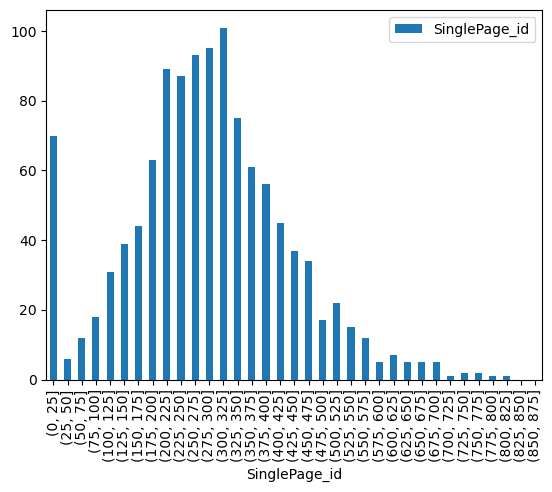

In [117]:
z = SinglePageByVolume.groupby(pd.cut(SinglePageByVolume["SinglePage_id"], np.arange(start=0, stop=900, step=25))).count()
z.plot.bar()

## Dimensions

In [33]:
df_singlePages.iat[0,0]

'France, Paris, Bibliothèque nationale de France, Manuscrits, nouv. acq. lat. 3196'

In [36]:
print(df_singlePages.iat[10000,5])
print(df_singlePages.iat[10000,7])

[[0, 0], [0, 7501], [5838, 7501], [5838, 0], [0, 0]]
[[1367, 645], [1425, 7109], [5635, 7070], [5567, 606], [1367, 645]]


In [37]:
%%time
# Transformer Page_polygon de string à liste de listes
# Transformer SinglePage_polygon de string à liste de listes
for i in range(len(df_singlePages)):
    df_singlePages.iat[i,5] = eval(df_singlePages.iat[i,5])
    df_singlePages.iat[i,7] = eval(df_singlePages.iat[i,7])

CPU times: user 25.3 s, sys: 145 ms, total: 25.4 s
Wall time: 25.5 s


In [38]:
df_singlePages.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height
0,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",5c1448ae-c015-4a3f-baea-48608c5feb5c,"[[694, 415], [694, 2931], [2429, 2931], [2429,...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,4,3,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496
1,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",dab2d9a5-9f18-4ed3-aeba-5bd6f51060b8,"[[2479, 2944], [4196, 2950], [4208, 402], [248...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,5,4,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496
2,"France, Poitiers, Bibliothèque municipale, 004...",9cc9609d-2d65-4ac0-9001-8937e8ee181a,242,0001b80e-c571-43f6-b79a-1b145a0f6fbc,244_Ms45_291_f119.jp2,"[[0, 0], [0, 4195], [2831, 4195], [2831, 0], [...",1b51951d-3275-4c21-9285-8407600605fa,"[[27, 4126], [2742, 4137], [2758, 65], [43, 54...",1c0150ef-14c2-4676-959a-e3696ef75fd1,single_page,1,0,1c0150ef-14c2-4676-959a-e3696ef75fd1,https://horae-pictavenses.fr/iiif-img/7340,2831,4195
3,"Suisse, Genève, Bibliothèque de Genève, Comite...",aeb01720-fb4a-4bff-94e5-4288cafee31e,385,0001c5f8-2c33-4355-a5ce-19b1e6f2d302,191v,"[[0, 0], [0, 8168], [6128, 8168], [6128, 0], [...",dc17a976-8720-45eb-926a-96e9666312b1,"[[563, 148], [563, 7777], [5977, 7777], [5977,...",13395e8a-19e1-4c3a-8637-6115fc44a27c,single_page,1,0,13395e8a-19e1-4c3a-8637-6115fc44a27c,https://www.e-codices.ch/loris/bge/bge-cl0054/...,6128,8168
4,"États-Unis, Cambridge, Harvard College Library...",6825f6ad-58aa-4c56-8af0-bd7596850108,256,0001f033-4d72-4fa8-8ee2-b60380670fa7,"f. 122., (seq. 257)","[[0, 0], [0, 4134], [3577, 4134], [3577, 0], [...",43254131-6142-4414-85f1-7b9d9319f467,"[[64, 3916], [2648, 3932], [2669, 247], [80, 2...",8e5583f4-7bf0-45bd-adfe-6eca0df9e890,single_page,1,0,8e5583f4-7bf0-45bd-adfe-6eca0df9e890,https://ids.lib.harvard.edu/ids/iiif/26121424,3577,4134


In [39]:
df_singlePages['SinglePage_reduced'] = df_singlePages['SinglePage_polygon']
df_singlePages.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height,SinglePage_reduced
0,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",5c1448ae-c015-4a3f-baea-48608c5feb5c,"[[694, 415], [694, 2931], [2429, 2931], [2429,...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,4,3,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"[[694, 415], [694, 2931], [2429, 2931], [2429,..."
1,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",dab2d9a5-9f18-4ed3-aeba-5bd6f51060b8,"[[2479, 2944], [4196, 2950], [4208, 402], [248...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,5,4,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"[[2479, 2944], [4196, 2950], [4208, 402], [248..."
2,"France, Poitiers, Bibliothèque municipale, 004...",9cc9609d-2d65-4ac0-9001-8937e8ee181a,242,0001b80e-c571-43f6-b79a-1b145a0f6fbc,244_Ms45_291_f119.jp2,"[[0, 0], [0, 4195], [2831, 4195], [2831, 0], [...",1b51951d-3275-4c21-9285-8407600605fa,"[[27, 4126], [2742, 4137], [2758, 65], [43, 54...",1c0150ef-14c2-4676-959a-e3696ef75fd1,single_page,1,0,1c0150ef-14c2-4676-959a-e3696ef75fd1,https://horae-pictavenses.fr/iiif-img/7340,2831,4195,"[[27, 4126], [2742, 4137], [2758, 65], [43, 54..."
3,"Suisse, Genève, Bibliothèque de Genève, Comite...",aeb01720-fb4a-4bff-94e5-4288cafee31e,385,0001c5f8-2c33-4355-a5ce-19b1e6f2d302,191v,"[[0, 0], [0, 8168], [6128, 8168], [6128, 0], [...",dc17a976-8720-45eb-926a-96e9666312b1,"[[563, 148], [563, 7777], [5977, 7777], [5977,...",13395e8a-19e1-4c3a-8637-6115fc44a27c,single_page,1,0,13395e8a-19e1-4c3a-8637-6115fc44a27c,https://www.e-codices.ch/loris/bge/bge-cl0054/...,6128,8168,"[[563, 148], [563, 7777], [5977, 7777], [5977,..."
4,"États-Unis, Cambridge, Harvard College Library...",6825f6ad-58aa-4c56-8af0-bd7596850108,256,0001f033-4d72-4fa8-8ee2-b60380670fa7,"f. 122., (seq. 257)","[[0, 0], [0, 4134], [3577, 4134], [3577, 0], [...",43254131-6142-4414-85f1-7b9d9319f467,"[[64, 3916], [2648, 3932], [2669, 247], [80, 2...",8e5583f4-7bf0-45bd-adfe-6eca0df9e890,single_page,1,0,8e5583f4-7bf0-45bd-adfe-6eca0df9e890,https://ids.lib.harvard.edu/ids/iiif/26121424,3577,4134,"[[64, 3916], [2648, 3932], [2669, 247], [80, 2..."


In [43]:
print(extrema_np(df_singlePages.iat[10000,5]), extrema_np(df_singlePages.iat[10000,7]))

(5838, 0, 7501, 0) (5635, 1367, 7109, 606)


In [44]:
%%time
for i in range(len(df_singlePages)):
    df_singlePages.iat[i, 16] = extrema_np(df_singlePages.iat[i,16])
df_singlePages.head()

CPU times: user 11 s, sys: 3.97 ms, total: 11 s
Wall time: 11 s


,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height,SinglePage_reduced
0,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",5c1448ae-c015-4a3f-baea-48608c5feb5c,"[[694, 415], [694, 2931], [2429, 2931], [2429,...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,4,3,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"(2429, 694, 2931, 415)"
1,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",dab2d9a5-9f18-4ed3-aeba-5bd6f51060b8,"[[2479, 2944], [4196, 2950], [4208, 402], [248...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,5,4,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"(4208, 2479, 2950, 396)"
2,"France, Poitiers, Bibliothèque municipale, 004...",9cc9609d-2d65-4ac0-9001-8937e8ee181a,242,0001b80e-c571-43f6-b79a-1b145a0f6fbc,244_Ms45_291_f119.jp2,"[[0, 0], [0, 4195], [2831, 4195], [2831, 0], [...",1b51951d-3275-4c21-9285-8407600605fa,"[[27, 4126], [2742, 4137], [2758, 65], [43, 54...",1c0150ef-14c2-4676-959a-e3696ef75fd1,single_page,1,0,1c0150ef-14c2-4676-959a-e3696ef75fd1,https://horae-pictavenses.fr/iiif-img/7340,2831,4195,"(2758, 27, 4137, 54)"
3,"Suisse, Genève, Bibliothèque de Genève, Comite...",aeb01720-fb4a-4bff-94e5-4288cafee31e,385,0001c5f8-2c33-4355-a5ce-19b1e6f2d302,191v,"[[0, 0], [0, 8168], [6128, 8168], [6128, 0], [...",dc17a976-8720-45eb-926a-96e9666312b1,"[[563, 148], [563, 7777], [5977, 7777], [5977,...",13395e8a-19e1-4c3a-8637-6115fc44a27c,single_page,1,0,13395e8a-19e1-4c3a-8637-6115fc44a27c,https://www.e-codices.ch/loris/bge/bge-cl0054/...,6128,8168,"(5977, 563, 7777, 148)"
4,"États-Unis, Cambridge, Harvard College Library...",6825f6ad-58aa-4c56-8af0-bd7596850108,256,0001f033-4d72-4fa8-8ee2-b60380670fa7,"f. 122., (seq. 257)","[[0, 0], [0, 4134], [3577, 4134], [3577, 0], [...",43254131-6142-4414-85f1-7b9d9319f467,"[[64, 3916], [2648, 3932], [2669, 247], [80, 2...",8e5583f4-7bf0-45bd-adfe-6eca0df9e890,single_page,1,0,8e5583f4-7bf0-45bd-adfe-6eca0df9e890,https://ids.lib.harvard.edu/ids/iiif/26121424,3577,4134,"(2669, 64, 3932, 231)"


In [45]:
%%time
for i in range(len(df_singlePages)):
    w = (df_singlePages.loc[i,"SinglePage_reduced"][0]-df_singlePages.loc[i,"SinglePage_reduced"][1])
    h = (df_singlePages.loc[i,"SinglePage_reduced"][2]-df_singlePages.loc[i,"SinglePage_reduced"][3])
    df_singlePages.loc[i,"SinglePage_width"] = (w)
    df_singlePages.loc[i,"SinglePage_height"] = (h)
df_singlePages.head()

CPU times: user 33.3 s, sys: 263 µs, total: 33.3 s
Wall time: 33.3 s


,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height,SinglePage_reduced,SinglePage_width,SinglePage_height
0,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",5c1448ae-c015-4a3f-baea-48608c5feb5c,"[[694, 415], [694, 2931], [2429, 2931], [2429,...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,4,3,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"(2429, 694, 2931, 415)",1735.0,2516.0
1,"France, Paris, Bibliothèque nationale de Franc...",031dfdd8-d3a9-4718-bcc0-32b946a705ac,152,00010adc-f971-40bb-8416-07e134786b18,NP,"[[0, 0], [0, 3496], [4760, 3496], [4760, 0], [...",dab2d9a5-9f18-4ed3-aeba-5bd6f51060b8,"[[2479, 2944], [4196, 2950], [4208, 402], [248...",1be67795-5ac6-4722-b7f7-94f397a82005,single_page,5,4,1be67795-5ac6-4722-b7f7-94f397a82005,https://gallica.bnf.fr/iiif/ark:/12148/btv1b10...,4760,3496,"(4208, 2479, 2950, 396)",1729.0,2554.0
2,"France, Poitiers, Bibliothèque municipale, 004...",9cc9609d-2d65-4ac0-9001-8937e8ee181a,242,0001b80e-c571-43f6-b79a-1b145a0f6fbc,244_Ms45_291_f119.jp2,"[[0, 0], [0, 4195], [2831, 4195], [2831, 0], [...",1b51951d-3275-4c21-9285-8407600605fa,"[[27, 4126], [2742, 4137], [2758, 65], [43, 54...",1c0150ef-14c2-4676-959a-e3696ef75fd1,single_page,1,0,1c0150ef-14c2-4676-959a-e3696ef75fd1,https://horae-pictavenses.fr/iiif-img/7340,2831,4195,"(2758, 27, 4137, 54)",2731.0,4083.0
3,"Suisse, Genève, Bibliothèque de Genève, Comite...",aeb01720-fb4a-4bff-94e5-4288cafee31e,385,0001c5f8-2c33-4355-a5ce-19b1e6f2d302,191v,"[[0, 0], [0, 8168], [6128, 8168], [6128, 0], [...",dc17a976-8720-45eb-926a-96e9666312b1,"[[563, 148], [563, 7777], [5977, 7777], [5977,...",13395e8a-19e1-4c3a-8637-6115fc44a27c,single_page,1,0,13395e8a-19e1-4c3a-8637-6115fc44a27c,https://www.e-codices.ch/loris/bge/bge-cl0054/...,6128,8168,"(5977, 563, 7777, 148)",5414.0,7629.0
4,"États-Unis, Cambridge, Harvard College Library...",6825f6ad-58aa-4c56-8af0-bd7596850108,256,0001f033-4d72-4fa8-8ee2-b60380670fa7,"f. 122., (seq. 257)","[[0, 0], [0, 4134], [3577, 4134], [3577, 0], [...",43254131-6142-4414-85f1-7b9d9319f467,"[[64, 3916], [2648, 3932], [2669, 247], [80, 2...",8e5583f4-7bf0-45bd-adfe-6eca0df9e890,single_page,1,0,8e5583f4-7bf0-45bd-adfe-6eca0df9e890,https://ids.lib.harvard.edu/ids/iiif/26121424,3577,4134,"(2669, 64, 3932, 231)",2605.0,3701.0


/home/stutzmann/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Axes: xlabel='SinglePage_width', ylabel='SinglePage_height'>

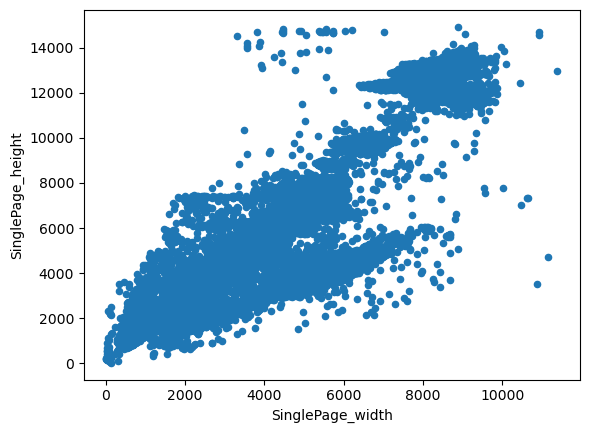

In [46]:
df_singlePages.plot.scatter(x = "SinglePage_width", y = "SinglePage_height")

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_fill_gradientn could not recognise parameter `alpha`


CPU times: user 6.64 ms, sys: 0 ns, total: 6.64 ms
Wall time: 6.65 ms


/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


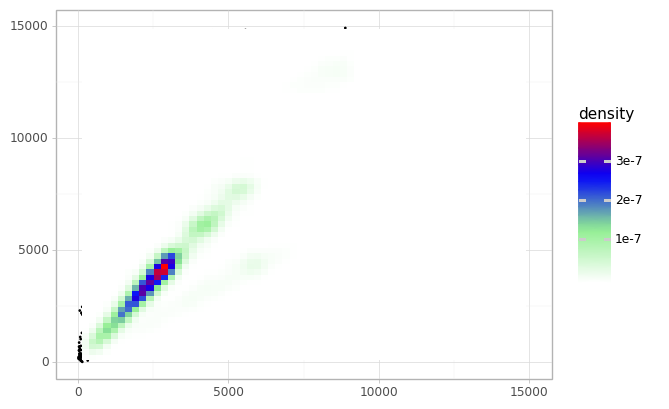

<ggplot: (8741765534031)>

In [66]:
%%time
q = (ggplot(df_singlePages, aes(x = "SinglePage_width", y = "SinglePage_height"))
    + theme_light()
    + labs(x=None,y=None)
    + geom_point(color='black', size=0.1) # alpha=0.5
    + xlim(0,15000)
    + ylim(0,15000)
     + stat_density_2d(aes(fill=after_stat('density')), geom='raster', contour=False, levels=0)
    + scale_fill_gradientn(colors = ("white", "lightgreen", "blue", "red"), alpha=0.01) #scale_fill_gradient2(low = "white", high = "red", midpoint = 0.5e-9) # mid = "#1A6AFF", 
     
  )
q

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scale.py:102: PlotnineWarning: scale_fill_gradientn could not recognise parameter `alpha`
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


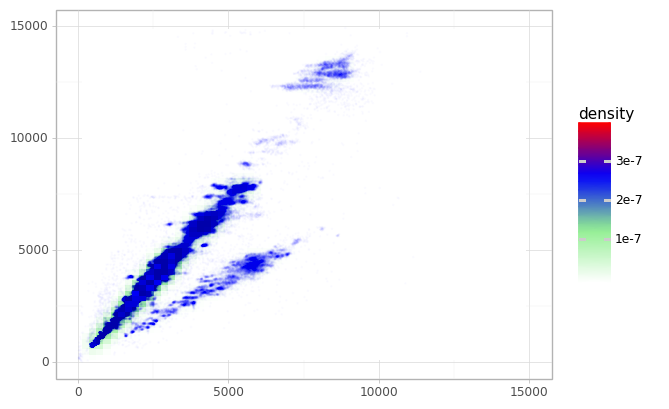

<ggplot: (8741726660084)>

In [67]:
r = (ggplot(df_singlePages, aes(x = "SinglePage_width", y = "SinglePage_height"))
    + theme_light()
    + labs(x=None,y=None)
    + xlim(0,15000)
    + ylim(0,15000)
    + stat_density_2d(aes(fill=after_stat('density')), geom='raster', contour=False, levels=0)
    + scale_fill_gradientn(colors = ("white", "lightgreen", "blue", "red"), alpha=0.01) #scale_fill_gradient2(low = "white", high = "red", midpoint = 0.5e-9) # mid = "#1A6AFF", 
    + geom_point(color='blue', size=0.1, alpha=0.01)
     
  )
r

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


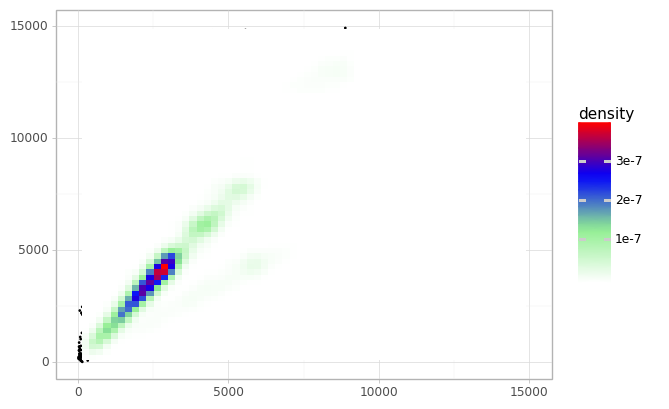

<ggplot: (8741765534031)>

In [68]:
q

In [69]:
%%time
ggsave(plot=q, filename='singlePages_sizes_density.png', dpi=1000)
ggsave(plot=r, filename='singlePages_sizes_scatter.png', dpi=1000)

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: singlePages_sizes_density.png
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: singlePages_sizes_scatter.png
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


CPU times: user 1min 24s, sys: 2.8 s, total: 1min 27s
Wall time: 1min 26s


### Linear Regression

#### Plot

In [81]:
%%time 
s = q + geom_smooth(method='lm')
ggsave(plot=s, filename='singlePages_linearRegression.png', dpi=1000)


/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: singlePages_linearRegression.png
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


CPU times: user 42 s, sys: 1.28 s, total: 43.3 s
Wall time: 42.8 s


/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_raster : Removed 252 rows containing missing values.


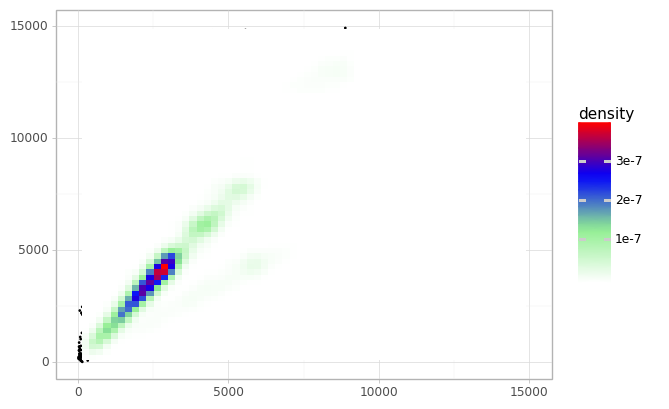

<ggplot: (8741765534031)>

In [ ]:
q

In [ ]:
%%time 
t = (q + geom_smooth(method='lm') + 
     scale_y_continuous(breaks=range(0, 15000, 500), minor_breaks=(4)) + 
     scale_x_continuous(breaks=range(0, 15000, 500), minor_breaks=(4)) + 
     theme(axis_text_x = element_text(angle = 90, hjust = 1)))
ggsave(plot=t, filename='singlePages_linearRegression_zoom2.png', dpi=1000)

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: singlePages_linearRegression_zoom2.png


CPU times: user 42 s, sys: 1.25 s, total: 43.2 s
Wall time: 42.8 s


In [87]:
%%time 
t = (q + geom_smooth(method='lm') + 
     scale_y_continuous(breaks=range(0, 15000, 500), minor_breaks=(4)) + 
     scale_x_continuous(breaks=range(0, 15000, 500), minor_breaks=(4)) + 
     theme(axis_text_x = element_text(angle = 90, hjust = 1)))
ggsave(plot=t, filename='singlePages_linearRegression_zoom2.png', dpi=1000)

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/scales/scales.py:36: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/stutzmann/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: singlePages_linearRegression_zoom2.png


CPU times: user 41.9 s, sys: 1.53 s, total: 43.4 s
Wall time: 42.9 s


#### Calculus

In [23]:
# https://realpython.com/linear-regression-in-python/


!pip install scikit-learn statsmodels
from sklearn.linear_model import LinearRegression

In [58]:
x = df_singlePages.loc[df_singlePages.index[:],"SinglePage_width"]
y = df_singlePages.loc[df_singlePages.index[:],"SinglePage_height"]

In [59]:
x = x.to_numpy().reshape((-1, 1))
y = y.to_numpy()

In [60]:
x

array([[1735.],
       [1729.],
       [2731.],
       ...,
       [3460.],
       [3342.],
       [3878.]])

In [61]:
y

array([2516., 2554., 4083., ..., 5234., 5152., 6044.])

In [63]:
model = LinearRegression().fit(x, y)

In [65]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.8237341308500057
intercept: 487.0879886853131
slope: [1.25234561]


### Outliers

In [70]:
outliers = df_singlePages.loc[df_singlePages['SinglePage_width'] > df_singlePages['SinglePage_height']]

In [71]:
len(outliers)

17845

In [80]:
pd.set_option('display.max_colwidth', 80)
print("https://arkindex.teklia.com/element/" + outliers.iloc[:,3])

25        https://arkindex.teklia.com/element/0004e17b-94c1-4879-9675-769b34bc8b85
65        https://arkindex.teklia.com/element/000bd7cd-49d0-4241-a519-4a002459a91d
66        https://arkindex.teklia.com/element/000bdd46-b8d6-4060-bcaa-24abe77affb3
82        https://arkindex.teklia.com/element/000f17a3-437e-4dd0-9464-4a451f284917
90        https://arkindex.teklia.com/element/001056c9-5e39-475e-8544-65fa68904a85
                                            ...                                   
331371    https://arkindex.teklia.com/element/ffedf8f4-e04f-4cfa-b801-bf65a36ed3bb
331372    https://arkindex.teklia.com/element/ffee47ff-c518-40c4-8e3f-97e4071152d4
331375    https://arkindex.teklia.com/element/ffef4274-adae-42d7-9ce5-2f0a457eeaa7
331406    https://arkindex.teklia.com/element/fff468a3-c21a-4a81-b57f-bb796febb8f9
331438    https://arkindex.teklia.com/element/fffbdccb-94db-4d3d-b036-1b4f646ae95c
Name: Page_id, Length: 17845, dtype: object


In [90]:
len(df_singlePages)

331460

# SinglePage and Transcription

In [5]:
print(df_singlePages.shape)
print(df_Lines.shape)

(698326, 16)


NameError: name 'df_Lines' is not defined

In [34]:
df_singlePages.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height
0,"Centre historique des Archives nationales, LL ...",00d047c1-6979-4a52-8e13-6e4c11e6dd7f,12,00007f28-d014-43f8-85a1-dc98ac83b7f2,f.,"[[0, 0], [0, 4360], [6260, 4360], [6260, 0], [...",aac8c1af-6542-461d-84c9-3917e8bca5e0,"[[236, 4051], [5788, 4124], [5837, 105], [285,...",cb0a2047-3c6a-4d3c-b4fa-b7f7320f43b1,single_page,1,0,cb0a2047-3c6a-4d3c-b4fa-b7f7320f43b1,https://iiif.irht.cnrs.fr/iiif/France/Paris/Ar...,6260,4360
1,"Archives départementales de Seine-et-Marne, H(...",7346db2f-4358-4749-b69d-1ef7d3dd3d2a,235,0000949d-941c-48fe-ae03-926e7ec06fcc,f.,"[[0, 0], [0, 4888], [6859, 4888], [6859, 0], [...",d1954459-879a-4817-afb9-0dddab5eeada,"[[169, 4706], [6290, 4751], [6326, 178], [205,...",ccdc262d-8818-4455-81e8-9836b09a56c0,single_page,1,0,ccdc262d-8818-4455-81e8-9836b09a56c0,https://iiif.irht.cnrs.fr/iiif/France/Melun/Ar...,6859,4888
2,"Archives départementales de l'Oise, H 4650, n° 3",8b786f21-10d9-4d1e-8a09-ec578bb19244,254,00015424-cc08-45cf-a33f-29f6bd5e41cc,f.,"[[0, 0], [0, 4984], [5850, 4984], [5850, 0], [...",d3478ccb-3215-41bd-a736-e1efc73d826a,"[[434, 4661], [2888, 4692], [2941, 304], [480,...",72519583-5d61-4906-9511-781df84a475c,single_page,1,0,72519583-5d61-4906-9511-781df84a475c,https://iiif.irht.cnrs.fr/iiif/France/Beauvais...,5850,4984
3,"Archives départementales de l'Oise, H 4650, n° 3",8b786f21-10d9-4d1e-8a09-ec578bb19244,254,00015424-cc08-45cf-a33f-29f6bd5e41cc,f.,"[[0, 0], [0, 4984], [5850, 4984], [5850, 0], [...",d87f4f73-a881-4001-969d-d5f850560ea0,"[[2926, 4692], [5365, 4722], [5426, 342], [298...",72519583-5d61-4906-9511-781df84a475c,single_page,2,1,72519583-5d61-4906-9511-781df84a475c,https://iiif.irht.cnrs.fr/iiif/France/Beauvais...,5850,4984
4,"Bibliothèque nationale de France, lat. 09908",15f191ea-c7cf-42f8-9743-7e88d18e55e7,33,00016828-c8f8-4458-afcd-6bbb7937cf61,NP,"[[0, 0], [0, 5361], [7380, 5361], [7380, 0], [...",1d4e3460-32f5-4fd5-8fd7-d38a9a47652a,"[[952, 576], [952, 4814], [3840, 4814], [3840,...",f466d38a-e444-4290-8268-bda3adc563ea,single_page,3,2,f466d38a-e444-4290-8268-bda3adc563ea,https://gallica.bnf.fr/iiif/ark:/12148/btv1b90...,7380,5361


In [35]:
#Arkindex semble montrer :
# ligne 1  : 2ec2b1aa-6479-4521-a6ab-4b4c8d438e7a      # eafbe07c-c164-4cdc-b122-99f2bd732ee0
# single Page : c3dbda7b-49cd-499d-a6ad-e4783667c099   # 3099cee4-4654-43bd-83f1-289074813c15
# page : 389c45d4-6de3-49f1-a4ac-621e42e9fd66
# AD Rhône, 15 G 003*, fichier 237

# DB Browser: 2ec2b1aa-6479-4521-a6ab-4b4c8d438e7a is child of c3dbda7b-49cd-499d-a6ad-e4783667c099 is child of 389c45d4-6de3-49f1-a4ac-621e42e9fd66

In [36]:
type(df_singlePages)

pandas.core.frame.DataFrame

In [6]:
%%time
df_singlePages = df_singlePages.sort_values(by=['Volume_name', 'Page_order'])

CPU times: user 266 ms, sys: 28.1 ms, total: 294 ms
Wall time: 293 ms


In [7]:
df_transLines.shape

(5848836, 8)

In [8]:
df_transLines.head()

,Line_id,Line_polygon,Image_id,Line_type,Line_name,SinglePage_id,Line_order,text
0,3690f397-0174-4f08-b793-8c5b3fe5dba5,"[[1738, 924], [3567, 945], [3567, 878], [1739,...",8f1e48d4-2553-4455-8f02-072ea0ebe21e,text_line,1,00038bc6-c49b-42f7-bbef-b61639b580a0,0,"cimiterio constituto , in ex in monasterium S..."
1,ce5de0bd-4799-4344-9970-b3b500f399ee,"[[1738, 1013], [3196, 1031], [3197, 968], [173...",8f1e48d4-2553-4455-8f02-072ea0ebe21e,text_line,2,00038bc6-c49b-42f7-bbef-b61639b580a0,1,"in quo debet se percelini monachi , et facien..."
2,34c1dea4-2459-46c1-9b77-26bce1aafa32,"[[1732, 1179], [3578, 1206], [3580, 1121], [17...",8f1e48d4-2553-4455-8f02-072ea0ebe21e,text_line,3,00038bc6-c49b-42f7-bbef-b61639b580a0,2,"ne consec ratione cauz , elle domus Dei Droce..."
3,a11494c2-9677-4f23-bbce-8b524544c85f,"[[1732, 1333], [3602, 1360], [3603, 1293], [17...",8f1e48d4-2553-4455-8f02-072ea0ebe21e,text_line,4,00038bc6-c49b-42f7-bbef-b61639b580a0,3,De venditione cujusdam decime factam Capitulo ...
4,539e348f-0f2b-4bcf-bef5-f6e637c09854,"[[1744, 1432], [3637, 1444], [3637, 1377], [17...",8f1e48d4-2553-4455-8f02-072ea0ebe21e,text_line,5,00038bc6-c49b-42f7-bbef-b61639b580a0,4,de Avinaunco de Chau Pei confiniaco et ejus ux...


In [19]:
b = df_transLines[df_transLines['SinglePage_id'].str.contains('3099cee4-4654-43bd-83f1-289074813c15', na=False)]

In [20]:
b

,Line_id,Line_polygon,Image_id,Line_type,Line_name,SinglePage_id,Line_order,text
1041848,eafbe07c-c164-4cdc-b122-99f2bd732ee0,"[[1180, 766], [1182, 825], [2894, 775], [2892,...",2598aa86-6021-471d-a628-3758769c1d24,text_line,1,3099cee4-4654-43bd-83f1-289074813c15,0,"Quintiniaco , capella cum decimis . Et in pa..."
1041849,c22faee2-b89b-4ca8-86ea-f797d13d1aec,"[[1181, 854], [1182, 903], [2866, 853], [2864,...",2598aa86-6021-471d-a628-3758769c1d24,text_line,2,3099cee4-4654-43bd-83f1-289074813c15,1,duinum colligendum que fuerunt beneficio Urso¬
1041850,74c57f92-dbd6-4fc2-b999-7d8ba15359de,"[[1181, 933], [1182, 988], [2900, 935], [2898,...",2598aa86-6021-471d-a628-3758769c1d24,text_line,3,3099cee4-4654-43bd-83f1-289074813c15,2,"nis Valdonis , atque Balduini et ibi ex alia ..."
1041851,547c87a9-85fc-458d-b769-96279fb350f1,"[[1187, 1019], [1188, 1070], [2889, 1022], [28...",2598aa86-6021-471d-a628-3758769c1d24,text_line,4,3099cee4-4654-43bd-83f1-289074813c15,3,et alie vinee ad modios in villa a Guilliaco C...
1041852,398291de-3ceb-470f-97dc-f87a55e3f939,"[[1186, 1103], [1188, 1154], [2844, 1103], [28...",2598aa86-6021-471d-a628-3758769c1d24,text_line,5,3099cee4-4654-43bd-83f1-289074813c15,4,una et in Colonica dimidia queducto Colonica
1041853,de0184d3-81c1-45a9-aee0-b8bb89268601,"[[1187, 1183], [1188, 1234], [2916, 1190], [29...",2598aa86-6021-471d-a628-3758769c1d24,text_line,6,3099cee4-4654-43bd-83f1-289074813c15,5,dimidia ibi exaumento domini episcopi ; Held...
1041854,a22b7d0f-a07c-458c-a2d2-43162c008c6d,"[[1192, 1270], [1193, 1318], [2877, 1272], [28...",2598aa86-6021-471d-a628-3758769c1d24,text_line,7,3099cee4-4654-43bd-83f1-289074813c15,6,electum et Colonas . Prudi . Adelina ; Ger...
1041855,17606207-d7b2-4024-85f5-8b93de00ab21,"[[1192, 1347], [1193, 1397], [2899, 1353], [28...",2598aa86-6021-471d-a628-3758769c1d24,text_line,8,3099cee4-4654-43bd-83f1-289074813c15,7,et maltrudunt . Cuius salutem et Flaagitation...
1041856,f91a3118-2e77-40a9-a41b-03fe3a7198bd,"[[1192, 1434], [1193, 1485], [2910, 1436], [29...",2598aa86-6021-471d-a628-3758769c1d24,text_line,9,3099cee4-4654-43bd-83f1-289074813c15,8,domni et Sanctissimi patre sue mansuetudinis c...
1041857,91093862-a0ab-4f87-9aa7-0db6adf08d98,"[[1192, 1515], [1193, 1568], [2894, 1522], [28...",2598aa86-6021-471d-a628-3758769c1d24,text_line,10,3099cee4-4654-43bd-83f1-289074813c15,9,supradicta constitutionem per hoc auctoritatis...


In [21]:
b.iat[0,7]

'Quintiniaco ,  capella cum decimis .  Et in patriniaco vil¬'

In [17]:
a = df_transLines.iat[0,7] + df_transLines.iat[1,7]

In [18]:
a

'cimiterio constituto ,  in ex in monasterium Sancti Martiniin quo debet se percelini monachi ,  et facient tum XVII .'

In [22]:
c = b.groupby('SinglePage_id').agg({'text': 'sum'}) 

In [23]:
c

,text
SinglePage_id,
3099cee4-4654-43bd-83f1-289074813c15,"Quintiniaco , capella cum decimis . Et in pa..."


In [28]:
c.iat[0,0]

'Quintiniaco ,  capella cum decimis .  Et in patriniaco vil¬duinum colligendum que fuerunt beneficio Urso¬nis Valdonis ,  atque Balduini et ibi ex alia parte Colonica dimi¬et alie vinee ad modios in villa a Guilliaco Colonicauna et in Colonica dimidia queducto Colonicadimidia ibi exaumento domini episcopi  ;  Heldierio .electum et Colonas .  Prudi .  Adelina  ;  Gerbergiaet maltrudunt .  Cuius salutem et Flaagitationibus supra scripti¬domni et Sanctissimi patre sue mansuetudinis commodan¬supradicta constitutionem per hoc auctoritatis privilegium confir¬laudaverunt tenore atque confirmando sua episcopali Sanctistatuerunt ut quemadmodum omnia supra scripta constituta ,  confir¬inata sunt et nos nostra ,  canonica et episcopali confirmamus aucto¬ritate .  Si quis autem temeraria sacrilegaque presumptione convictuscupiditate hoc quod Dei et nostra confirmamus auc¬toritate in aliquo confratringere presumpserit ,  eterna se sciens damnatione multandum cum diabolo et Angulis ejus sempiterno i

In [29]:
df_singlePages_text = df_transLines.groupby('SinglePage_id').agg({'text': 'sum'}) 

In [30]:
df_singlePages_text.head()

,text
SinglePage_id,
000054a2-1ab6-423a-8dc4-c69cef6f87c0,Charles nobis suscipuctur celes¬non coloribus ...
0000b018-0dc9-45e1-9c1f-7e34cd135b04,dictus sexan¬inquod cumetex. . .et nostrepre...
0000bae2-ff9f-41f0-b412-04093a10f077,Domini Mo DE UNO MODE ODO MODE UNO MOSDE UNO H...
0000c9ba-7361-4825-9473-58356e450851,et con¬in manu mortua et venditionis nomine im...
0000d2c7-2863-4595-b975-0ce1ff326a7e,Ego iusticien¬et omnia laud relaret exnunicari...


In [31]:
df_singlePages_2 = pd.merge(df_singlePages, df_singlePages_text, left_on='SinglePage_id', right_index=True)
# type_df, time_df, left_index=True, right_on='Project')

In [32]:
df_singlePages_2.head()

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height,SinglePage_text,text
206634,Archives de l'Association diocésaine de Soisso...,0373a0d3-5d15-47e8-9cab-d472a62bccbb,0,4be614ea-585e-41b2-81ff-776046d821ac,f.,"[[0, 0], [0, 4152], [6264, 4152], [6264, 0], [...",6188dc16-0237-4f42-90ae-087b31d33d13,"[[65, 3980], [6134, 4021], [6158, 171], [97, 1...",1a903cb1-4abd-466d-af97-f8ca16c1d439,single_page,3,2,1a903cb1-4abd-466d-af97-f8ca16c1d439,https://iiif.irht.cnrs.fr/iiif/France/Soissons...,6264,4152,None,etrebus ecclesie in omnibus quod Hugoquem debo...
333944,Archives de l'Association diocésaine de Soisso...,0373a0d3-5d15-47e8-9cab-d472a62bccbb,1,7a8b73b0-83fa-44b0-bfab-c68d94b574d0,f.,"[[0, 0], [0, 4168], [6296, 4168], [6296, 0], [...",0937ca06-17cc-49e3-85aa-bb0f66110e80,"[[98, 180], [123, 4041], [3167, 4025], [3142, ...",a36f0a1a-c39b-45af-a377-13be1611b6a5,single_page,1,0,a36f0a1a-c39b-45af-a377-13be1611b6a5,https://iiif.irht.cnrs.fr/iiif/France/Soissons...,6296,4168,None,Aubenti¬munimentum Reneri Domini de suimus de ...
333945,Archives de l'Association diocésaine de Soisso...,0373a0d3-5d15-47e8-9cab-d472a62bccbb,1,7a8b73b0-83fa-44b0-bfab-c68d94b574d0,f.,"[[0, 0], [0, 4168], [6296, 4168], [6296, 0], [...",ad4b3289-13c6-4ef1-9cef-02ee41aa5e77,"[[3191, 4033], [6178, 4049], [6194, 131], [321...",a36f0a1a-c39b-45af-a377-13be1611b6a5,single_page,2,1,a36f0a1a-c39b-45af-a377-13be1611b6a5,https://iiif.irht.cnrs.fr/iiif/France/Soissons...,6296,4168,None,"turis , quia ecclesia Sancti Iohannis de abba..."
188768,Archives de l'Association diocésaine de Soisso...,0373a0d3-5d15-47e8-9cab-d472a62bccbb,2,45544e18-f455-4bf7-b687-6d947abcf151,f.,"[[0, 0], [0, 4152], [6248, 4152], [6248, 0], [...",04a2a3fa-f4f4-4a72-9697-e3b842f3fa43,"[[89, 284], [89, 3953], [3069, 3953], [3069, 2...",47e3ada9-9034-4166-85ab-cea92a93b39f,single_page,2,1,47e3ada9-9034-4166-85ab-cea92a93b39f,https://iiif.irht.cnrs.fr/iiif/France/Soissons...,6248,4152,None,"uxor sua , Guilla et filius . Volrico , Wib..."
188769,Archives de l'Association diocésaine de Soisso...,0373a0d3-5d15-47e8-9cab-d472a62bccbb,2,45544e18-f455-4bf7-b687-6d947abcf151,f.,"[[0, 0], [0, 4152], [6248, 4152], [6248, 0], [...",b3907c7d-a954-4c0b-9164-915aac41302d,"[[3134, 146], [3134, 4010], [6146, 4010], [614...",47e3ada9-9034-4166-85ab-cea92a93b39f,single_page,1,0,47e3ada9-9034-4166-85ab-cea92a93b39f,https://iiif.irht.cnrs.fr/iiif/France/Soissons...,6248,4152,None,aliis . Horum testes sunt : Eligius Cleremu...


In [33]:
df_singlePages_2.iat[0,17]

'etrebus ecclesie in omnibus quod Hugoquem debonis Sancto Michaei quam im¬enActumBas de Carium nostrum .  Notumfuturis quam presentibus ,  nos ratam habe¬nem quam fecit adduinus conversus Dei grati¬concessit ,  clmidiam partem terreetconsensu et voluntate fratris sui subjecit ecclesie Vallisea conditione quod easdem filiusHoc enim ,  uxore et in elemosinam con¬non tenus enfratre suo Ioberto Croient cause ,  omni cons¬Envel expectabas in predicto quod eidem cons¬Omnibus ratione con¬tris sue jure hereditario ,  contingebatusriorum ,  Drogo Ermini de Fontanis qui eas ecclesie parin curie Parisiensis ,  omnibus presentesecclesiam Sancti Io ,  Hugo ad censum tenebat annu¬ad nemus Sanctiinter cetero absque eiusorum capitulo ipsam vineistam fratribus susniacensis ecclesie vendidit donan¬licet ratione nemorum ad ecclesiam Colinerus ,  dominusomnibus in hosbertus se ferons tenu¬atim ecclesie nostre ,  in festo Sancti Remigii ,  viginti et uniusdenarios bos vel monete ,  censuales cum omnibus sc

In [34]:
#Cartulaire d'abbeville
# 2251-d090-6d9a-4e67-9535-587cf0f65051
a = df_singlePages_2[df_singlePages_2['Volume_id'] == '2251-d090-6d9a-4e67-9535-587cf0f65051']

In [35]:
a

,Volume_name,Volume_id,Page_order,Page_id,Page_name,Page_polygon,SinglePage_id,SinglePage_polygon,Image_id,SinglePage_type,SinglePage_name,SinglePage_order,Image_id2,Image_url,Image_width,Image_height,SinglePage_text,text
